In [14]:
# Necessary imports
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import glob
import re
from IPython.display import Image 
from IPython.core.display import HTML 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from time import time
import matplotlib.pyplot as plt
import random

import re

from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from operator import itemgetter

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

print('Libraries imported!')

Libraries imported!


In [2]:
df = pd.read_csv('../data/filtered_data.csv', index_col=0)
df.head()

,Name,Description,Full_Review,Tasting_Info
0,Mezcal de Leyendas Verde San Luis Potosi Mezca...,Mezcal de Leyendas Review Verde San Luis Potos...,"Clear color. Aromas and flavors of cucumber, m...","Fruity, Funky, Rich, Spicy, Smoky, Herbal & Co..."
1,El Tesoro Paradiso Tequila Extra Anejo Mexico ...,El Tesoro Review Paradiso Tequila Extra Anejo ...,"Gold color. Inviting aromas of roasted nuts, c...","Fruity, Complex, Candied, Herbal, Rich & Spicy..."
2,Peloton de la Muerte Vegan Pechuga Mezcal Mexi...,Peloton de la Muerte Review Vegan Pechuga Mezc...,Silvery straw color. Citrusy aromas and flavor...,"Complex, Fruity & Herbal | pickled melon and p..."
3,El Tesoro Anejo Tequila Mexico Spirits,El Tesoro Review Anejo Tequila Mexico Mexican ...,Straw color. Inviting aromas and flavors of ho...,"Fruity, Spicy & Herbal | honey-drizzled grapef..."
4,1800 Milenio Extra Anejo Tequila Mexico Spirits,1800 Review Milenio Extra Anejo Tequila Mexico...,"Amber color. Aromas of toffee coated popcorn, ...","Fruity, Rich & Spicy | toffee coated popcorn, ..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8319 entries, 0 to 8318
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          8319 non-null   object
 1   Description   8319 non-null   object
 2   Full_Review   7274 non-null   object
 3   Tasting_Info  8319 non-null   object
dtypes: object(4)
memory usage: 325.0+ KB


In [4]:
full_df = pd.read_csv('../data/cleaned_reviews_data.csv', index_col=0)
full_df.head()

,Name,Description,Category,Country,Alcohol_Vol,Review,Style,Aroma,Flavor,Sweetness,...,Price,Points_Ranking,Price_Range,Extend_Review,Photo_Link,Medal,Bands,Medal_Rank,Bands_Rank,Photo_Link_2
0,Mezcal de Leyendas Verde San Luis Potosi Mezca...,Mezcal de Leyendas Review Verde San Luis Potos...,Blanco Mezcal,Mexico,45%,"Clear color. Aromas and flavors of cucumber, m...","Fruity, Funky, Rich, Spicy, Smoky, Herbal & Co...","cucumber-melon, lime spritz, caramelized orang...","Same as aromas with notes of pickled ginger, s...",NaN,...,49.0,High,Mid Range,Blanco mezcal is a spirit from Mexico that can...,https://www.tastings.com/images-BTI/Glasses/Sp...,Platinum Medal,Superlative,5.0,5.0,https://www.tastings.com/Product-Images/Spirit...
1,El Tesoro Paradiso Tequila Extra Anejo Mexico ...,El Tesoro Review Paradiso Tequila Extra Anejo ...,Extra Añejo Tequila,Mexico,40%,"Gold color. Inviting aromas of roasted nuts, c...","Fruity, Complex, Candied, Herbal, Rich & Spicy","roasted nuts, candied cherries, vanilla bean, ...","ripe melons, toffee, and white pepper",NaN,...,180.0,High,Expensive,An extra añejo tequila must be aged for at lea...,https://www.tastings.com/images-BTI/Glasses/Sp...,Platinum Medal,Superlative,5.0,5.0,https://www.tastings.com/Product-Images/Spirit...
2,Peloton de la Muerte Vegan Pechuga Mezcal Mexi...,Peloton de la Muerte Review Vegan Pechuga Mezc...,Flavored Mezcal,Mexico,45.10%,Silvery straw color. Citrusy aromas and flavor...,"Complex, Fruity & Herbal","pickled melon and pineapple, candied jalapeño,...",Same as aromas with suggestions of curry,NaN,...,44.0,High,Mid Range,A Flavored Mezcal is an agave-based distillate...,https://www.tastings.com/images-BTI/Glasses/Sp...,Platinum Medal,Superlative,5.0,5.0,https://www.tastings.com/Product-Images/Spirit...
3,El Tesoro Anejo Tequila Mexico Spirits,El Tesoro Review Anejo Tequila Mexico Mexican ...,Añejo Tequila,Mexico,40%,Straw color. Inviting aromas and flavors of ho...,"Fruity, Spicy & Herbal","honey-drizzled grapefruit, sweet apple compote...","Same as aromas with notes of pink peppercorns,...",NaN,...,85.0,High,Expensive,"Añejo (""old"") Tequila is aged in wooden barrel...",https://www.tastings.com/images-BTI/Glasses/Sp...,Platinum Medal,Superlative,5.0,5.0,https://www.tastings.com/Product-Images/Spirit...
4,1800 Milenio Extra Anejo Tequila Mexico Spirits,1800 Review Milenio Extra Anejo Tequila Mexico...,Extra Añejo Tequila,Mexico,40%,"Amber color. Aromas of toffee coated popcorn, ...","Fruity, Rich & Spicy","toffee coated popcorn, peanuts, warm madeira c...","allspice, mint tea, candied ginger, honey, and...",NaN,...,250.0,High,Expensive,An extra añejo tequila must be aged for at lea...,https://www.tastings.com/images-BTI/Glasses/Sp...,Platinum Medal,Superlative,5.0,5.0,https://www.tastings.com/Product-Images/Spirit...


In [5]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8319 entries, 0 to 8318
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            8319 non-null   object 
 1   Description     8319 non-null   object 
 2   Category        7322 non-null   object 
 3   Country         7317 non-null   object 
 4   Alcohol_Vol     7322 non-null   object 
 5   Review          7322 non-null   object 
 6   Style           7286 non-null   object 
 7   Aroma           7303 non-null   object 
 8   Flavor          7301 non-null   object 
 9   Sweetness       5225 non-null   object 
 10  Bitterness      438 non-null    object 
 11  Enjoy           7303 non-null   object 
 12  Pairing         5509 non-null   object 
 13  Cocktails       1315 non-null   object 
 14  Bottom_Line     7322 non-null   object 
 15  Points          6224 non-null   float64
 16  Price           6554 non-null   float64
 17  Points_Ranking  6224 non-null   o

In [15]:
import random

random.seed(42)


sw = ['color', 'colors', 'aroma', 'aromas', 'flavor', 'flavors', 'review', 'taste', 'tasting', 'pair', 'pairing', 'oz', 'simple', 'dash', 'bsp', 'drops']
stop_words = ENGLISH_STOP_WORDS.union(sw)


def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub(r'[^\w\s]','',each) for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    #text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text

In [54]:


def text_cleaning(texts):
    #lowercase
    texts = texts.apply(lambda x: x.lower())

    #Remove puntuations
    texts = texts.apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove numbers
    texts = texts.apply(lambda x: re.sub(r'\d+', '', x))
    
    return texts

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Review topic modeling

In [8]:
reviews = df['Full_Review'].fillna(value='')

reviews = text_cleaning(reviews)

tfidf = TfidfVectorizer(max_df=0.5, stop_words=stop_words)

reviews_matrix = tfidf.fit_transform(reviews)

reviews_vocabs = tfidf.get_feature_names()

In [9]:
for review in reviews.sample(5).values:
    print(review)
    print('\n')

pale old gold color aromas of tinned pineapple fallen peach and lemon tisane with a soft dryish lighttomedium body and an even fleeting chalk and sawdust finish a possible base for a wine spritzer chardonnay is arguably the worlds most famous white variety thanks to its success in frances burgundy region as well as throughout much of california chardonnay on its own has rather straightforward pleasant aromas of apple and pear but when aged and sometimes fermented in small oak barrels the wines take on extra richness as well as notes of toasted almond vanilla and yeast the most renowned examples of chardonnay are from small villages and vineyards in burgundy such as chassagnemontrachet pulignymontrachet and meursault these wines are very powerful with ample spicy notes and very good acidity they age very well sometimes as long as  years another part of burgundy chablis is home to more restrained style of chardonnay certain areas of california especially russian river valley in sonoma an

### NMF

In [201]:
reviews = full_df['Review'].fillna(value='')

reviews = text_cleaning(reviews)

tfidf_review = TfidfVectorizer(stop_words=stop_words,
                           min_df=3,
                           max_df=0.7)

reviews_matrix = tfidf_review.fit_transform(reviews)

vocabs_review = tfidf_review.get_feature_names()

nmf_review = NMF(n_components=20)

nmf_review.fit(reviews_matrix)

reviews_matrix = nmf_review.transform(reviews_matrix)

reviews_df = pd.DataFrame(reviews_matrix).add_prefix('topic_')

reviews_df['Review'] = reviews

reviews_df.head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,Review
0,0.000000,0.031213,0.010792,0.062182,0.000000,0.004937,0.000000,0.001898,0.044511,0.000000,...,0.000000,0.017433,0.020065,0.000000,0.003215,0.000000,0.003060,0.000000,0.003575,clear color aromas and flavors of cucumber mel...
1,0.000000,0.019692,0.039298,0.040409,0.000000,0.000000,0.000000,0.000000,0.006781,0.000000,...,0.000000,0.000000,0.033089,0.031360,0.000000,0.000000,0.000000,0.000000,0.000000,gold color inviting aromas of roasted nuts can...
2,0.001254,0.000000,0.000000,0.000287,0.011370,0.061775,0.000000,0.019895,0.027036,0.000000,...,0.004315,0.015917,0.001376,0.014285,0.032861,0.000000,0.035491,0.023347,0.000000,silvery straw color citrusy aromas and flavors...
3,0.000000,0.021437,0.025506,0.082070,0.000122,0.018411,0.000000,0.040223,0.030756,0.030908,...,0.000000,0.000727,0.000000,0.006496,0.000000,0.003788,0.000000,0.000000,0.002714,straw color inviting aromas and flavors of hon...
4,0.000000,0.005016,0.079746,0.009767,0.000000,0.002193,0.000000,0.000000,0.007377,0.000000,...,0.005601,0.006696,0.000407,0.007112,0.008234,0.000000,0.000000,0.001277,0.000000,amber color aromas of toffee coated popcorn pe...
5,0.000000,0.004336,0.000000,0.029585,0.002559,0.000000,0.000000,0.000000,0.042817,0.000000,...,0.000000,0.012088,0.000000,0.007843,0.000000,0.000000,0.002165,0.000000,0.002840,clear color savory aromas and flavors of marin...
6,0.000000,0.006718,0.008411,0.071155,0.000000,0.001004,0.000000,0.000000,0.032869,0.000000,...,0.001158,0.003261,0.014691,0.000000,0.000000,0.000000,0.008834,0.000000,0.000000,clear color savory aromas of sweet chili sauce...
7,0.006752,0.006927,0.010908,0.026999,0.000000,0.009967,0.000000,0.000000,0.000000,0.001009,...,0.010348,0.000000,0.000000,0.004492,0.007890,0.005384,0.000000,0.000000,0.004017,straw yellow color savory aromas and flavors o...
8,0.000000,0.000000,0.112124,0.000000,0.001668,0.000000,0.093101,0.031426,0.005825,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048087,0.000000,0.005373,amber color aromas of molasses roasted figs ho...
9,0.002114,0.013133,0.004774,0.040108,0.003350,0.000000,0.000000,0.079145,0.038727,0.000000,...,0.000000,0.022196,0.000000,0.000000,0.000003,0.000000,0.051062,0.000000,0.000790,clear color aromas of sweet tea gunpowder gril...


In [96]:
reviews_word_df = pd.DataFrame(nmf_review.components_.round(5), columns=vocabs_review).T.add_prefix('topic_')

reviews_word_df.head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
abbey,0.00000,0.00012,0.00000,0.00000,0.00001,0.00015,0.00014,0.00091,0.00000,0.00039
abbreviated,0.00000,0.00045,0.00000,0.00000,0.00002,0.00107,0.00107,0.00199,0.00000,0.00099
ability,0.00128,0.00012,0.00000,0.00070,0.00000,0.00153,0.00043,0.00248,0.00459,0.00000
abound,0.00365,0.00000,0.00007,0.00322,0.00176,0.00021,0.00091,0.00014,0.00080,0.00183
abrasive,0.00000,0.00016,0.00000,0.00037,0.00011,0.00074,0.00114,0.00265,0.00004,0.00160
abruzzo,0.00639,0.00180,0.00226,0.00000,0.01071,0.00000,0.00000,0.01396,0.00384,0.00000
absinthe,0.00044,0.00000,0.00000,0.00000,0.00000,0.00171,0.00221,0.00255,0.00000,0.00582
absolute,0.00000,0.00000,0.00000,0.00037,0.00095,0.00000,0.00000,0.00216,0.00000,0.00003
absolutely,0.00263,0.00008,0.00019,0.00006,0.00055,0.00000,0.00081,0.00115,0.00259,0.00030
abundant,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00385,0.00000,0.00029,0.11987


In [202]:
display_topics(nmf_review, vocabs_review, 10)


Topic  0
chardonnay, pineapple, golden, yellow, straw, oak, lighttomedium, apples, toasty, toasted

Topic  1
black, violet, moderate, vibrant, cabernet, mediumfull, oak, plum, tea, long

Topic  2
amber, caramel, whiskey, chocolate, toasted, golden, complex, bourbon, dark, warming

Topic  3
sweet, moderately, wine, candies, spritzy, candied, peach, syrup, fun, liqueur

Topic  4
light, supple, dryish, brisk, soft, smooth, quaffer, bright, breezy, crisp

Topic  5
blanc, sauvignon, fresh, grapefruit, lime, straw, grass, gooseberry, green, emerald

Topic  6
chewy, slightly, tannins, moderate, crisp, oak, dryish, dark, dusty, mediumlength

Topic  7
apple, green, cider, straw, tangy, breezy, supple, melon, skin, sleek

Topic  8
clear, vodka, cocktails, gin, pepper, hints, lime, juniper, peppery, crisp

Topic  9
pink, strawberry, coral, rose, watermelon, rosé, steely, cherry, pale, oak

Topic  10
roasted, nuts, bright, spiced, silky, savory, fine, mediumlong, grilled, mediumtofull

Topic  11


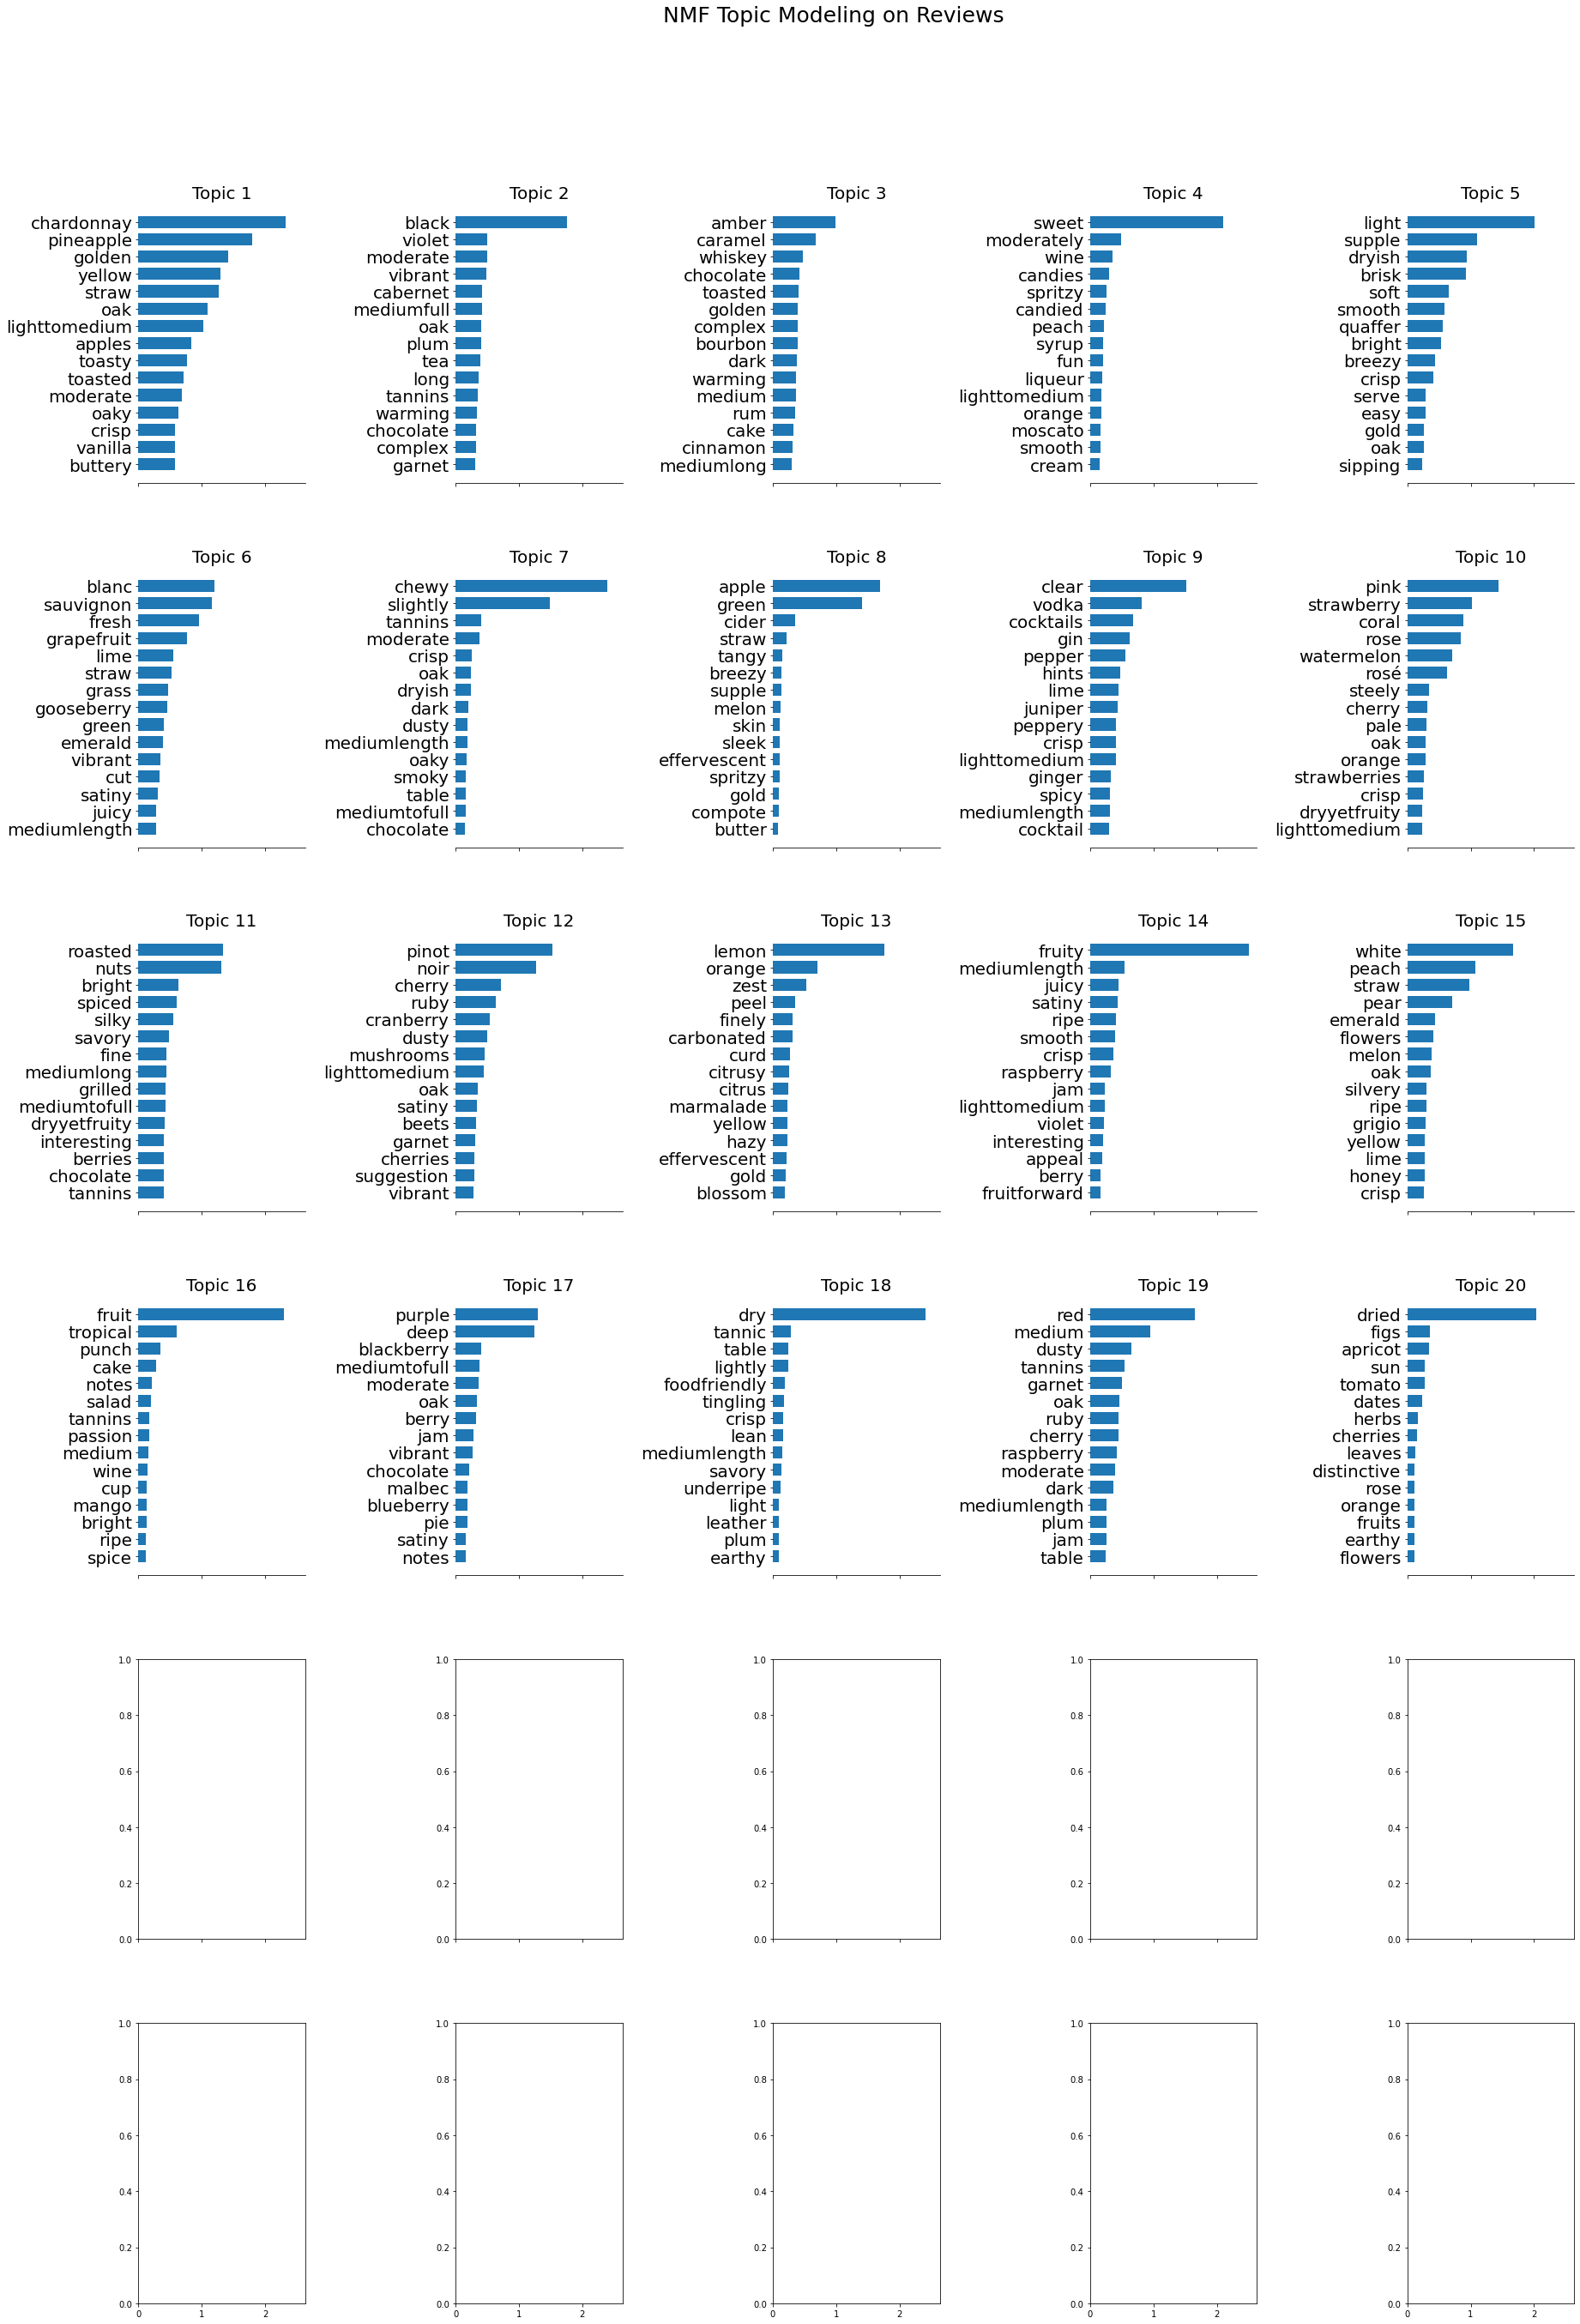

In [203]:
plot_top_words(nmf_review, vocabs_review, 15, "NMF Topic Modeling on Reviews")

In [208]:
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
test_item = ['cab']
topic_prob_dist = nmf_review.transform(tfidf_review.transform(test_item))
list_top_items_by_indices = list(cosine_similarity(topic_prob_dist, reviews_matrix).argsort())[0][-1:-200:-1]
full_df.iloc[list_top_items_by_indices].sort_values(by='Points', ascending=False)[:5]


,Name,Description,Category,Country,Alcohol_Vol,Review,Style,Aroma,Flavor,Sweetness,...,Points,Price,Points_Ranking,Price_Range,Extend_Review,Photo_Link,Medal,Bands,Medal_Rank,Bands_Rank
975,Paradise Ridge 2018 Branham Vineyard Malbec Ro...,Paradise Ridge Review Malbec Branham Vineyard ...,Malbec,USA,13.8%,Deep purple color. Inviting aromas and flavors...,"Fruity, Juicy & Smooth, Oaky, Rich & Full & Sp...","boysenberry, fine leather, coconut cream, shor...",Same as aromas with overtones of hints of choc...,Dry-yet-Fruity,...,95.0,58.0,High,Medium,While Malbec is historically known as a red Bo...,https://www.tastings.com/images-BTI/Glasses/Wi...,Gold Medal,Exceptional,4.0,4.0
980,Basalt Cellars 2018 Malbec Washington USA Wine,Basalt Cellars Review Malbec 2018 WA Washingto...,Malbec,USA,14.4%,Deep purple color. Aromas and flavors of ripe ...,"Fruity, Juicy & Smooth, Oaky & Rich & Full","ripe blackberries, huckleberry, blood orange, ...",Same as aromas with accents of honey-roasted n...,Dry-yet-Fruity,...,94.0,28.0,Medium,Medium,While Malbec is historically known as a red Bo...,https://www.tastings.com/images-BTI/Glasses/Wi...,Gold Medal,Exceptional,4.0,4.0
3087,Oak Farm Vineyards 2019 Hohenrieder Single Vin...,Oak Farm Vineyards Review Zinfandel Hohenriede...,Zinfandel,USA,15.50%,Deep purple color. Herbal aromas and flavors o...,"Fruity, Juicy & Smooth, Oaky, Rich & Full & Sp...","crushed blackberries, eucalyptus, black tea wi...",Same as aromas with suggestions of hints of ri...,Fruity,...,94.0,35.0,Medium,Medium,Zinfandel first came to American shores by way...,https://www.tastings.com/images-BTI/Glasses/Wi...,Gold Medal,Exceptional,4.0,4.0
7858,Corner 103 2016 Syrah Sonoma Mountain USA Wine,Corner 103 Review Syrah 2016 CA California USA...,Syrah,USA,15.5% RS: .07%,Deep purple color. Aromas and flavors of peppe...,"Fruity, Juicy & Smooth, New World, Oaky, Savor...","peppermint chocolate bar, blue eucalyptus, men...","Same as aromas with notes of exotic spices, da...",Fruity,...,94.0,50.0,Medium,Medium,"Syrah - also known as Shiraz, especially in Au...",https://www.tastings.com/images-BTI/Glasses/Wi...,Gold Medal,Exceptional,4.0,4.0
4510,Cline 2017 Live Oak Vineyard Zinfandel Contra ...,Cline Review Zinfandel Live Oak Vineyard 2017 ...,Zinfandel,USA,15.5% RS: <1%,"Deep purple color. Aromas of fresh blackberry,...","Fruity, Juicy & Smooth, Oaky, Rich & Full & Sp...","fresh blackberry, peony, and wild mint","ripe strawberry, milk chocolate, and lemon curd",Fruity,...,94.0,29.0,Medium,Medium,Zinfandel first came to American shores by way...,https://www.tastings.com/images-BTI/Glasses/Wi...,Gold Medal,Exceptional,4.0,4.0


### Topic exploration

#### Topic_0

In [12]:
for review in reviews_df.sort_values(by='topic_0', ascending=False).head(10)['Full_Review'].values:
    print(review)
    print('\n')
reviews_word_df.sort_values(by='topic_0', ascending=False).head(10).topic_0

black ruby color aromas of red cassis boysenberry strawberry black tea and bay with a satiny vibrant dryyetfruity mediumtofull body and a tingling compelling mediumlength cedar and tart cherry finish with moderate oak flavor a vibrant buoyant sonoma cabernet with great aging potential cabernet sauvignon is a variety that is the source of some of the worlds most celebrated and longestlived reds grown in many countries it is most famous in bordeaux where it is the principal grape in red bordeaux as well as in california  especially napa valley where it is labeled by its varietal namecabernet sauvignon has aromas and flavors of black currant cassis black cherry and sometimes plum in warmer regions or vintages quite rich on the palate the variety is very tannic giving its wines a bitter edge in their youth but also providing the wines with great aging potential with top flight examples drinking well for as long as four or five decades given their richness and flavor profile wines made from

sauvignon    1.76325
cabernet     1.69618
black        1.35645
bordeaux     1.06850
regions      1.01271
wines        1.01199
countries    0.96961
rich         0.88415
red          0.87755
variety      0.79975
Name: topic_0, dtype: float64

#### Topic_1

In [13]:
for review in reviews_df.sort_values(by='topic_1', ascending=False).head(10)['Full_Review'].values:
    print(review)
    print('\n')
reviews_word_df.sort_values(by='topic_1', ascending=False).head(10).topic_1

light gold color aromas and flavors of tea with lemon and thyme with a satiny crisp petillant fruity lighttomedium body and a smooth mediumlength finish displaying notes of pineapple and pastry with light oak flavor a bright foodfriendly chardonnay chardonnay is arguably the worlds most famous white variety thanks to its success in frances burgundy region as well as throughout much of california chardonnay on its own has rather straightforward pleasant aromas of apple and pear but when aged and sometimes fermented in small oak barrels the wines take on extra richness as well as notes of toasted almond vanilla and yeast the most renowned examples of chardonnay are from small villages and vineyards in burgundy such as chassagnemontrachet pulignymontrachet and meursault these wines are very powerful with ample spicy notes and very good acidity they age very well sometimes as long as  years another part of burgundy chablis is home to more restrained style of chardonnay certain areas of cal

chardonnay    2.07930
burgundy      0.85910
aged          0.71037
small         0.70709
california    0.56641
barrels       0.52807
richness      0.51674
home          0.50795
spicy         0.46021
style         0.45797
Name: topic_1, dtype: float64

#### Topic_2

In [14]:
for review in reviews_df.sort_values(by='topic_2', ascending=False).head(10)['Full_Review'].values:
    print(review)
    print('\n')
reviews_word_df.sort_values(by='topic_2', ascending=False).head(10).topic_2

light garnet color aromas and flavors of cherry lozenge spiced plum smoked mushrooms sesame and chocolate with a satiny crisp dryyetfruity light body and a polished mediumlength finish with moderate oak flavor a simple pinot noir with wide appeal pinot noir is one of the worlds most fascinating red varieties while many red grapes produces wines of power and youthful intensity a wine made from pinot noir is often more refined with higher acidity and lower levels of tannins the spiritual home for pinot noir is burgundy where it is produced in many styles from very light to examples that can age for two to three decades pinot noirs tend to have aromas and flavors red cherry fruit while some offer notes of wild strawberry plum or even floral notes such as carnation and red roses as tannins in pinot noir are not as pronounced as in a grape such as cabernet sauvignon or nebbiolo most pinot noirs can be enjoyed upon release which is usually two to three years after the vintage burgundy works 

pinot       2.23469
noir        1.51578
noirs       0.84479
burgundy    0.66819
red         0.56715
climate     0.53983
tannins     0.52420
tend        0.51201
notes       0.31502
valley      0.29808
Name: topic_2, dtype: float64

#### Topic_3

In [15]:
for review in reviews_df.sort_values(by='topic_3', ascending=False).head(10)['Full_Review'].values:
    print(review)
    print('\n')
reviews_word_df.sort_values(by='topic_3', ascending=False).head(10).topic_3

pink coral color aromas and flavors of watermelon candies cherry yogurt and white strawberry with a supple crisp dryish light body and a smooth breezy finish with no oak flavor a solid crisp rosé with a mild flavor profile rosé refers to a wine made when red grapes are given slight skin contact to produce a blush light copper salmon or pink color rosés range from bonedry to medium sweet and are made in most major wine producing countries among the most famous examples are tavel from frances rhone valley numerous offerings from provence in southern france as well as several excellent versions from puglia in southern italyoften thought of as a summer wine  in this case a substitute for red wine when the weather is hot  they can be enjoyed year round the drier versions of course are meat for food pairings recommended matches include chicken salad vegetables and seafood such as tuna or salmon especially with a rich rosé made from cabernet sauvignon or pinot noir


bright pink coral color a

rosé          1.16252
wine          0.97650
salmon        0.91287
southern      0.87000
pink          0.72552
versions      0.65092
red           0.55340
provence      0.52041
rosés         0.51877
italyoften    0.51701
Name: topic_3, dtype: float64

#### Topic_4

In [16]:
for review in reviews_df.sort_values(by='topic_4', ascending=False).head(10)['Full_Review'].values:
    print(review)
    print('\n')
reviews_word_df.sort_values(by='topic_4', ascending=False).head(10).topic_4

black garnet color aromas and flavors of red and black licorice roasted beets in pomegranate vinaigrette and minestrone with a satiny crisp fruity lighttomedium body and a tingling intriguing mediumlength finish with light oak flavor a rich and savory red for the table other red is a catchall category for both uncommon grape varietals and uncommon combinations of varietals there are little pockets of other red varietals grown throughout the us in california italian varietals such as barbera gignolino primitivo and nebbiolo and esoteric rhone varietals like cinsault and carignano can be found tempranillo best known as the principal red variety of spains rioja can also be found in small plantings in the southwest where hot grown conditions favor the grape many producers throughout the us produce blends of bordeaux with nonbordeaux varietals such as zinfandel petit sirah syrah and even hybrids like chambourcin that fall under our other us red category


ruby color aromas of grilled berrie

varietals    1.73302
zinfandel    1.54388
red          0.98035
uncommon     0.70017
like         0.53408
old          0.53146
grape        0.52235
category     0.51454
grown        0.44790
plantings    0.44713
Name: topic_4, dtype: float64

## Description topic modeling

In [53]:
df.head()

,Name,Description,Full_Review,Tasting_Info
0,Mezcal de Leyendas Verde San Luis Potosi Mezca...,Mezcal de Leyendas Review Verde San Luis Potos...,"Clear color. Aromas and flavors of cucumber, m...","Fruity, Funky, Rich, Spicy, Smoky, Herbal & Co..."
1,El Tesoro Paradiso Tequila Extra Anejo Mexico ...,El Tesoro Review Paradiso Tequila Extra Anejo ...,"Gold color. Inviting aromas of roasted nuts, c...","Fruity, Complex, Candied, Herbal, Rich & Spicy..."
2,Peloton de la Muerte Vegan Pechuga Mezcal Mexi...,Peloton de la Muerte Review Vegan Pechuga Mezc...,Silvery straw color. Citrusy aromas and flavor...,"Complex, Fruity & Herbal | pickled melon and p..."
3,El Tesoro Anejo Tequila Mexico Spirits,El Tesoro Review Anejo Tequila Mexico Mexican ...,Straw color. Inviting aromas and flavors of ho...,"Fruity, Spicy & Herbal | honey-drizzled grapef..."
4,1800 Milenio Extra Anejo Tequila Mexico Spirits,1800 Review Milenio Extra Anejo Tequila Mexico...,"Amber color. Aromas of toffee coated popcorn, ...","Fruity, Rich & Spicy | toffee coated popcorn, ..."


In [ ]:
# descriptions = descriptions.append(pd.Series(test_item), ignore_index=True)

In [17]:
descriptions = df['Description'].fillna('')

descriptions = text_cleaning(descriptions)

descriptions

0       mezcal de leyendas review verde san luis potos...
1       el tesoro review paradiso tequila extra anejo ...
2       peloton de la muerte review vegan pechuga mezc...
3       el tesoro review anejo tequila mexico mexican ...
4        review milenio extra anejo tequila mexico mex...
                              ...                        
8314    angry orchard review super natural cider ma ma...
8315    avid cider review apricot cider or oregon usa ...
8316    magnotta craft ciders review apple flavored ci...
8317    topa review brut artisanal cidre france french...
8318    angry orchard review strawman farmhouse hard c...
Name: Description, Length: 8319, dtype: object

In [131]:
df['processed_description'] = df['Description'].apply(process_text)

In [121]:
df.head()

,Name,Description,Full_Review,Tasting_Info,processed_description
0,Mezcal de Leyendas Verde San Luis Potosi Mezca...,Mezcal de Leyendas Review Verde San Luis Potos...,"Clear color. Aromas and flavors of cucumber, m...","Fruity, Funky, Rich, Spicy, Smoky, Herbal & Co...","[mezcal, leyenda, verd, san, lui, potosi, mezc..."
1,El Tesoro Paradiso Tequila Extra Anejo Mexico ...,El Tesoro Review Paradiso Tequila Extra Anejo ...,"Gold color. Inviting aromas of roasted nuts, c...","Fruity, Complex, Candied, Herbal, Rich & Spicy...","[el, tesoro, paradiso, tequila, extra, anejo, ..."
2,Peloton de la Muerte Vegan Pechuga Mezcal Mexi...,Peloton de la Muerte Review Vegan Pechuga Mezc...,Silvery straw color. Citrusy aromas and flavor...,"Complex, Fruity & Herbal | pickled melon and p...","[peloton, la, muert, vegan, pechuga, mezcal, m..."
3,El Tesoro Anejo Tequila Mexico Spirits,El Tesoro Review Anejo Tequila Mexico Mexican ...,Straw color. Inviting aromas and flavors of ho...,"Fruity, Spicy & Herbal | honey-drizzled grapef...","[el, tesoro, anejo, tequila, mexico, mexican, ..."
4,1800 Milenio Extra Anejo Tequila Mexico Spirits,1800 Review Milenio Extra Anejo Tequila Mexico...,"Amber color. Aromas of toffee coated popcorn, ...","Fruity, Rich & Spicy | toffee coated popcorn, ...","[milenio, extra, anejo, tequila, mexico, mexic..."


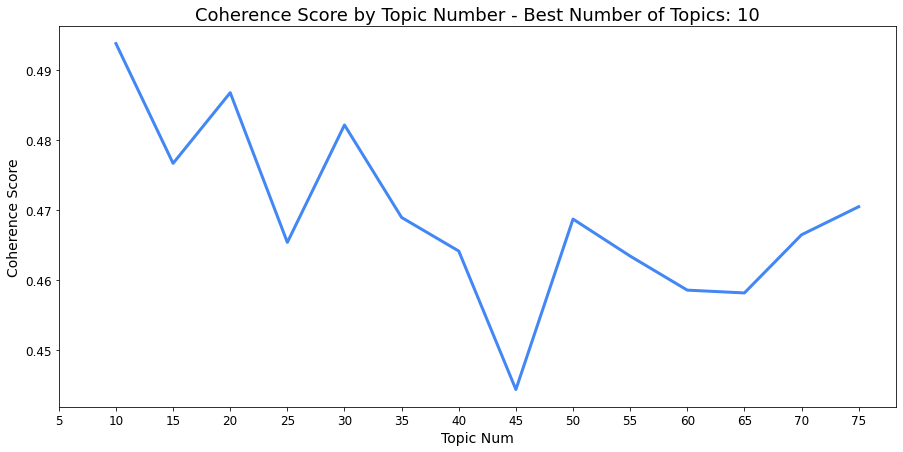

<Figure size 432x288 with 0 Axes>

In [138]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['processed_description']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(10, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)


plt.show()
plt.savefig('scores.png')

In [118]:
df['Description']

0       Mezcal de Leyendas Review Verde San Luis Potos...
1       El Tesoro Review Paradiso Tequila Extra Anejo ...
2       Peloton de la Muerte Review Vegan Pechuga Mezc...
3       El Tesoro Review Anejo Tequila Mexico Mexican ...
4       1800 Review Milenio Extra Anejo Tequila Mexico...
                              ...                        
8314    Angry Orchard Review Super Natural Cider MA Ma...
8315    Avid Cider Review Apricot Cider OR Oregon USA ...
8316    Magnotta Craft Ciders Review Apple Flavored Ci...
8317    Topa Review Brut Artisanal Cidre France French...
8318    Angry Orchard Review Strawman Farmhouse Hard C...
Name: Description, Length: 8319, dtype: object

In [76]:
full_df[['Price_Range', 'Bands']]

,Price_Range,Bands
0,Medium,Superlative
1,Expensive,Superlative
2,Medium,Superlative
3,Expensive,Superlative
4,Expensive,Superlative
...,...,...
8314,NaN,Recommended
8315,NaN,Recommended
8316,NaN,Recommended
8317,NaN,Recommended


In [80]:
df['Description'].fillna('') + ' ' + full_df['Price_Range'].fillna('')

0       Mezcal de Leyendas Review Verde San Luis Potos...
1       El Tesoro Review Paradiso Tequila Extra Anejo ...
2       Peloton de la Muerte Review Vegan Pechuga Mezc...
3       El Tesoro Review Anejo Tequila Mexico Mexican ...
4       1800 Review Milenio Extra Anejo Tequila Mexico...
                              ...                        
8314    Angry Orchard Review Super Natural Cider MA Ma...
8315    Avid Cider Review Apricot Cider OR Oregon USA ...
8316    Magnotta Craft Ciders Review Apple Flavored Ci...
8317    Topa Review Brut Artisanal Cidre France French...
8318    Angry Orchard Review Strawman Farmhouse Hard C...
Length: 8319, dtype: object

In [8]:
descriptions = df['Description'].fillna('') + ' ' + full_df['Price_Range'].fillna('')

descriptions = text_cleaning(descriptions)

tfidf_des = TfidfVectorizer(stop_words=stop_words,
                           min_df=3,
                           max_df=0.7) #tfidf vectorizer: used to transform new text data to to through the nmf

des_matrix = tfidf_des.fit_transform(descriptions)

vocabs_des = tfidf_des.get_feature_names()

nmf_des = NMF(10)

des_matrix = nmf_des.fit_transform(des_matrix) #nmf model to transform new text data

des_df = pd.DataFrame(des_matrix).add_prefix('topic_')

des_df['Description'] = full_df['Description']

des_df.tail()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,Description
8314,0.000000,0.000000,0.0,0.000000,0.255309,0.000000,0.000000,0.000000,0.001332,0.000000,Angry Orchard Review Super Natural Cider MA Ma...
8315,0.000490,0.000000,0.0,0.000000,0.249252,0.005028,0.000000,0.000000,0.000000,0.000045,Avid Cider Review Apricot Cider OR Oregon USA ...
8316,0.003848,0.000000,0.0,0.023352,0.209920,0.000000,0.000000,0.000000,0.000000,0.000560,Magnotta Craft Ciders Review Apple Flavored Ci...
8317,0.000000,0.002387,0.0,0.000200,0.163242,0.002718,0.000000,0.008579,0.000673,0.000000,Topa Review Brut Artisanal Cidre France French...
8318,0.000000,0.000000,0.0,0.000000,0.238559,0.000000,0.016072,0.000000,0.000000,0.000000,Angry Orchard Review Strawman Farmhouse Hard C...


In [120]:
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
test_item = ['cheap scotch']
topic_prob_dist = nmf_des.transform(tfidf_des.transform(test_item))
list_top_items_by_indices = list(cosine_similarity(topic_prob_dist, des_matrix).argsort())[0][-1:-6:-1]
top_items = full_df.iloc[list_top_items_by_indices]
top_items

,Name,Description,Category,Country,Alcohol_Vol,Review,Style,Aroma,Flavor,Sweetness,...,Price,Points_Ranking,Price_Range,Extend_Review,Photo_Link,Medal,Bands,Medal_Rank,Bands_Rank,Photo_Link_2
1563,Bird Dog Honey Jalapeno Flavored Whiskey USA S...,Bird Dog Review Honey Jalapeno Flavored Whiske...,Flavored Whiskey,USA,40%,Amber color. Aromas of beeswax and chamomile w...,Rich,beeswax and chamomile,"white flowers, honey on biscuits, caramel, and...",NaN,...,19.0,Low,Cheap,Flavored whiskeys are distilled alcoholic beve...,https://www.tastings.com/images-BTI/Glasses/Sp...,Silver Medal,Highly Recommended,3.0,3.0,https://www.tastings.com/Product-Images/Spirit...
1564,Bird Dog Chocolate Flavored Whiskey USA Spirits,Bird Dog Review Chocolate Flavored Whiskey KY ...,Flavored Whiskey,USA,40%,Amber color. Confected aromas of caramel corn ...,Candied,caramel corn and chocolate frosting,chocolate sprinkles and tootsie rolls,NaN,...,19.0,Low,Cheap,Flavored whiskeys are distilled alcoholic beve...,https://www.tastings.com/images-BTI/Glasses/Sp...,Silver Medal,Highly Recommended,3.0,3.0,https://www.tastings.com/Product-Images/Spirit...
5862,Bird Dog Apple Whiskey USA Spirits,Bird Dog Review Apple Whiskey KY Kentucky USA ...,Flavored Whiskey,USA,40%,Amber color. Aromas of green apple jolly ranch...,Candied & Fruity,green apple jolly rancher and caramel-apple pop,"caramel candies, kettle corn, honey roasted nu...",NaN,...,19.0,Low,Cheap,Flavored whiskeys are distilled alcoholic beve...,https://www.tastings.com/images-BTI/Glasses/Sp...,Silver Medal,Highly Recommended,3.0,3.0,https://www.tastings.com/Product-Images/Spirit...
3653,Bird Dog Black Cherry Flavored Whiskey USA Spi...,Bird Dog Review Black Cherry Flavored Whiskey ...,Flavored Whiskey,USA,40%,Golden amber color. Aromas and flavors of mara...,Candied & Fruity,"maraschino cherry, marzipan, and apricot stone",Same as aromas with accents of almond cookie,NaN,...,19.0,NaN,Cheap,Flavored whiskeys are distilled alcoholic beve...,https://www.tastings.com/images-BTI/Glasses/Sp...,Bronze Medal,Recommended,2.0,2.0,https://www.tastings.com/Product-Images/Spirit...
1582,Bird Dog Ruby Red Grapefruit Flavored Whiskey ...,Bird Dog Review Ruby Red Grapefruit Flavored W...,Flavored Whiskey,USA,40%,Golden amber color. Citrusy aromas of orange z...,Fruity & Candied,"orange zest, hints of caramel, and grapefruit ...",tangerine and orange hi-c,NaN,...,19.0,Low,Cheap,Flavored whiskeys are distilled alcoholic beve...,https://www.tastings.com/images-BTI/Glasses/Sp...,Silver Medal,Highly Recommended,3.0,3.0,https://www.tastings.com/Product-Images/Spirit...


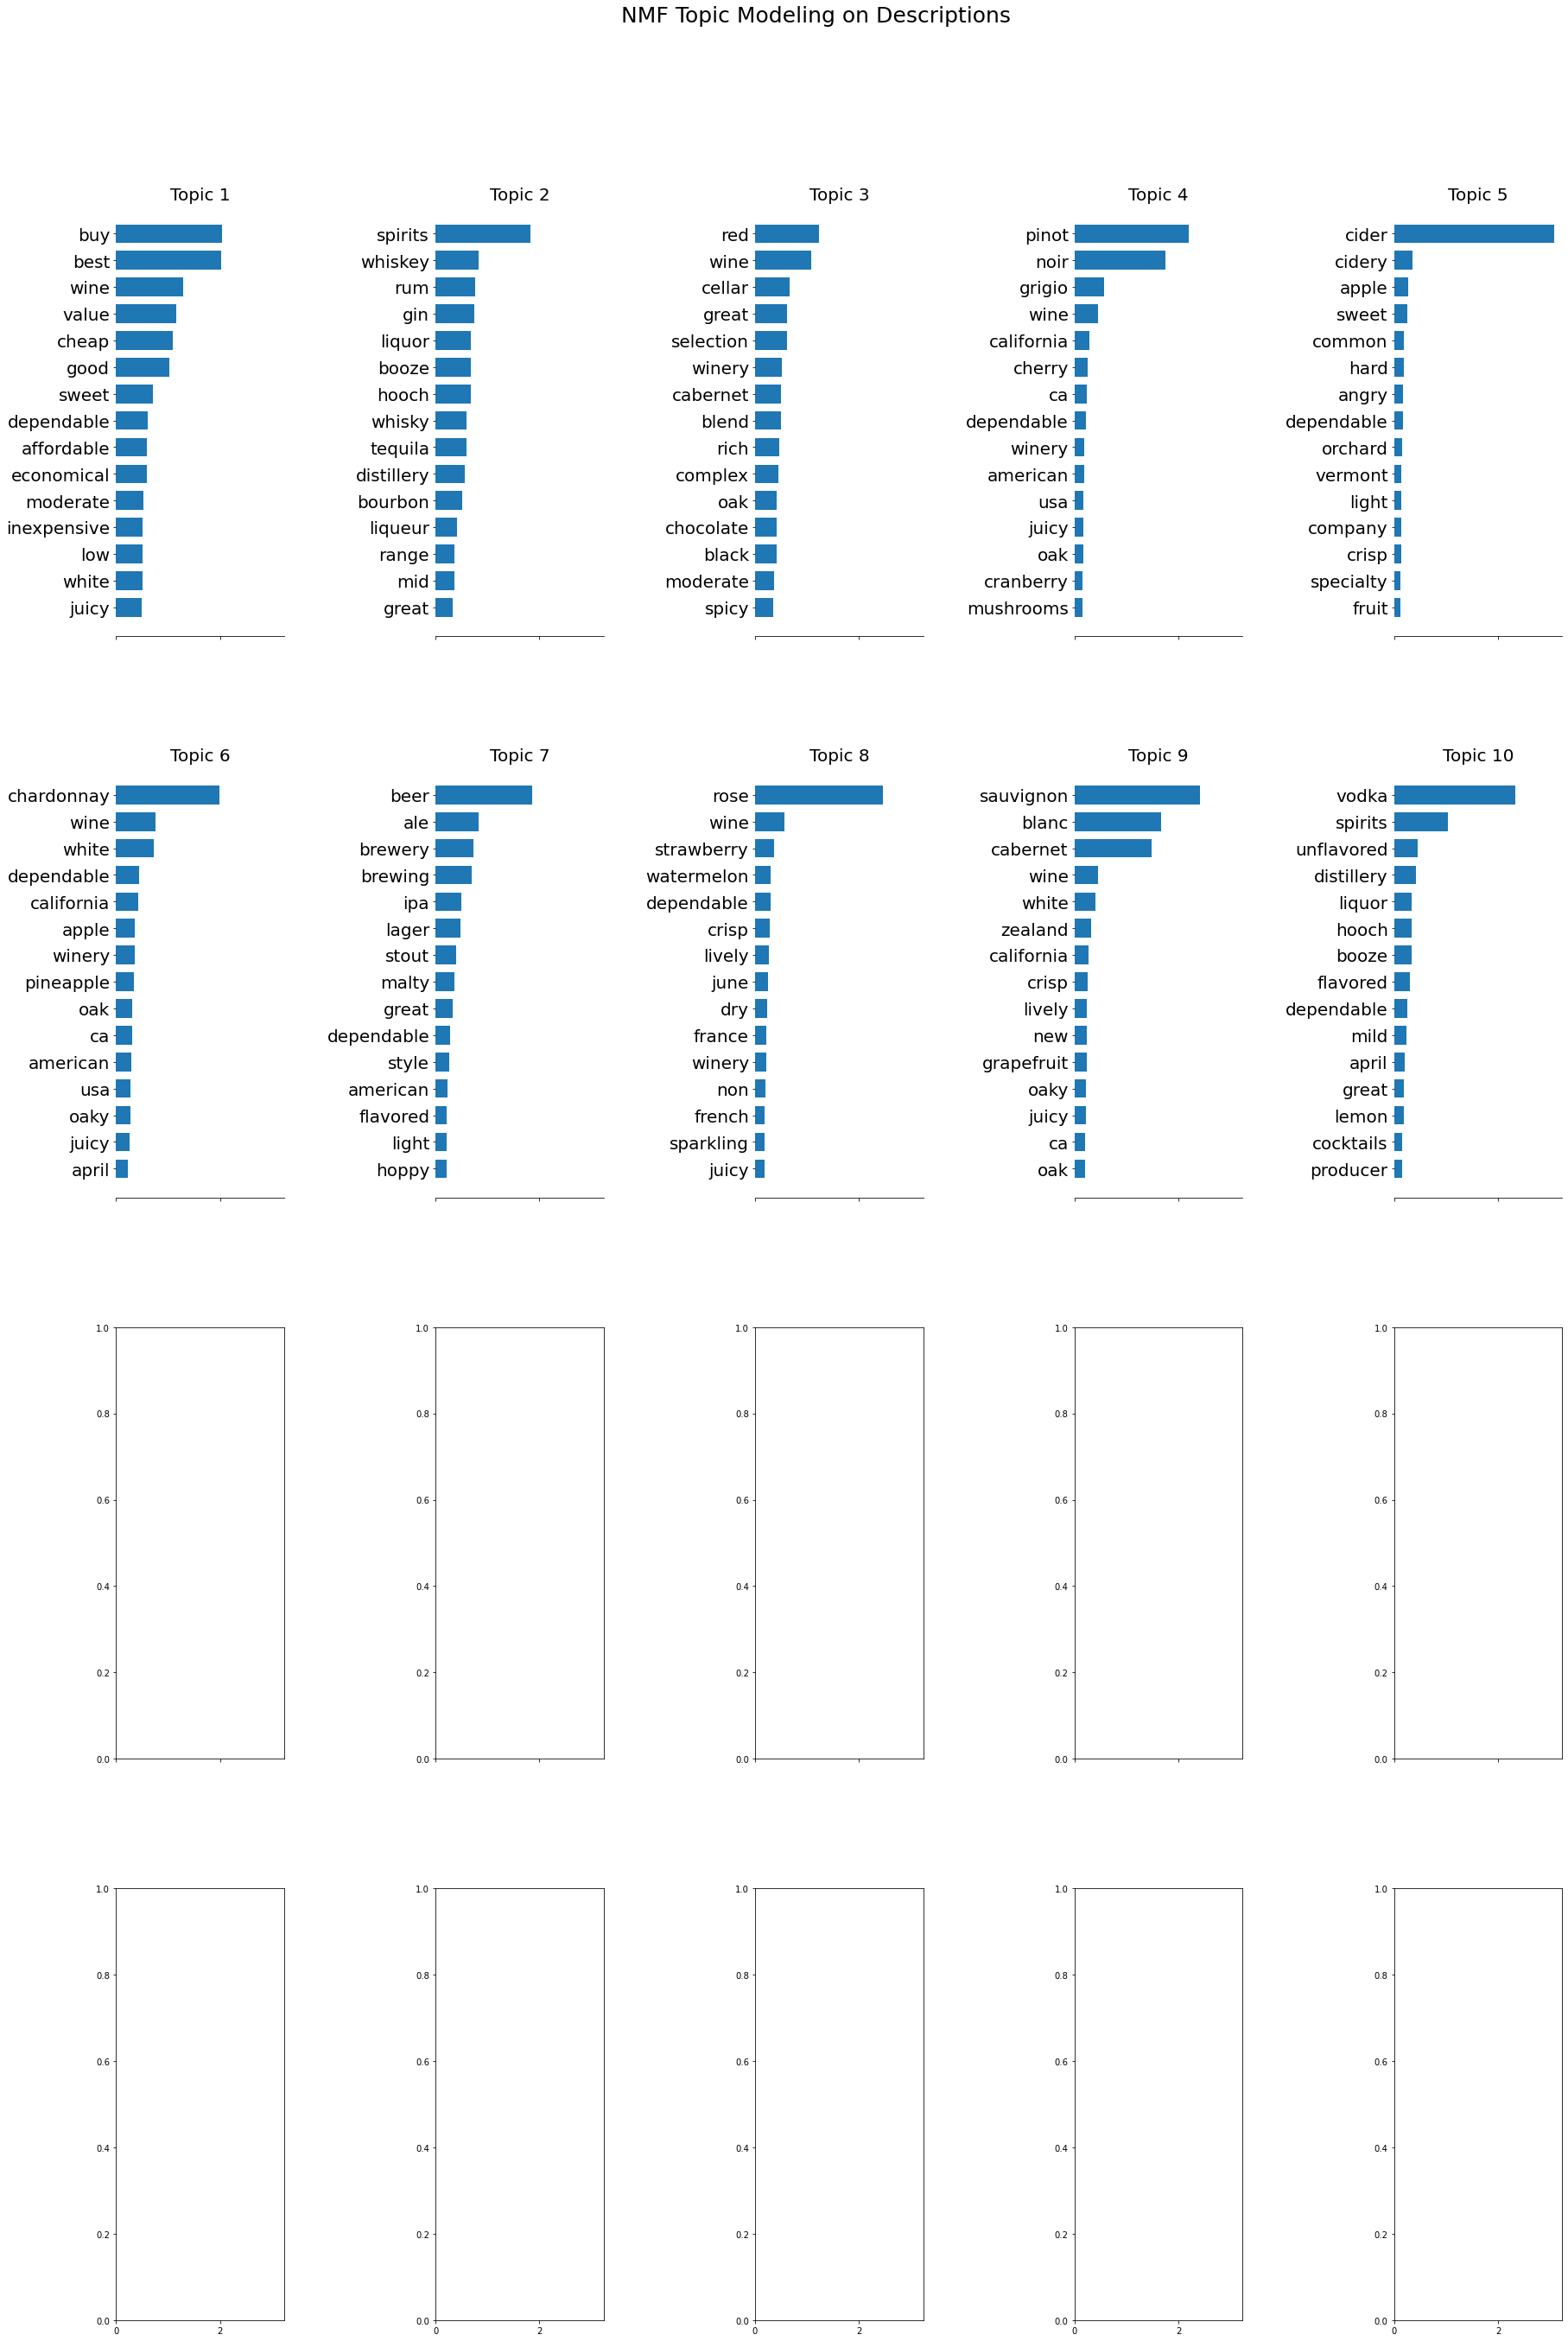

In [11]:
plot_top_words(nmf_des, vocabs_des, 15, "NMF Topic Modeling on Descriptions")

In [232]:
top_items.columns

Index(['Name', 'Description', 'Category', 'Country', 'Alcohol_Vol', 'Review',
       'Style', 'Aroma', 'Flavor', 'Sweetness', 'Bitterness', 'Enjoy',
       'Pairing', 'Cocktails', 'Bottom_Line', 'Points', 'Price',
       'Points_Ranking', 'Price_Range', 'Extend_Review', 'Photo_Link', 'Medal',
       'Bands', 'Medal_Rank', 'Bands_Rank'],
      dtype='object')

In [121]:

print('Name: {}\nCountry: {}\nAlcohol Volume: {}\nAroma: {}\nFlavor: {}\nPrice: ${}'.
      format(top_items.iloc[0].Name, top_items.iloc[0].Country, top_items.iloc[0].Alcohol_Vol,
            top_items.iloc[0].Aroma, top_items.iloc[0].Flavor, top_items.iloc[0].Price))

Name: Bird Dog Honey Jalapeno Flavored Whiskey USA Spirits
Country: USA
Alcohol Volume: 40%
Aroma: beeswax and chamomile
Flavor: white flowers, honey on biscuits, caramel, and sliced hot peppers
Price: $19.0


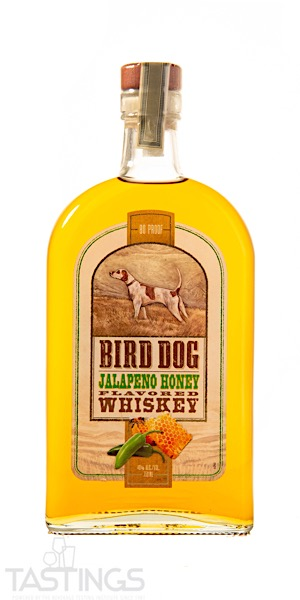

In [122]:

Image(top_items.iloc[0].Photo_Link_2, width=127, height=228)

In [124]:
import pickle
with open('topics_by_description.pkl', 'wb') as wf:
    pickle.dump(des_df, wf)
with open('topics_by_description_matrix.pkl', 'wb') as wf:
    pickle.dump(des_matrix, wf)
with open('tfidf_description.pkl', 'wb') as wf:
    pickle.dump(tfidf_des, wf)
with open('nmf_description.pkl', 'wb') as wf:
    pickle.dump(nmf_des, wf)

#### Topic_0

In [36]:
des_word_df = pd.DataFrame(nmf_des.components_.round(5), columns=vocabs_des).T.add_prefix('topic_')

In [43]:
for description in des_df.sort_values(by='topic_1', ascending=False).head(10)['Description'].values:
    print(description)
    print('\n')
des_word_df.sort_values(by='topic_1', ascending=False).head(10).topic_1

Chicken Cock Review Kentucky Straight Bourbon Whiskey KY Kentucky USA US Spirits Straight Bourbon Whiskey 229736 Whisky Spirits Tasting Note Flavor Description Mild Smooth Dryish Charming vanilla custard sweet corn buttercream honey and brown sugar molasses cookies and roasted pecans A rock solid smooth sipping bourbon that gives people what they want! Gold Medal November 2019 Rating $5999 92 Points Luxury Price Expensive High Priced American Grain and Barrel Spirits Liquor Booze Hooch Great Spirits Producer Great Distillery


Boulder Review Straight Bourbon Whiskey CO Colorado USA US Spirits Straight Bourbon Whiskey 230107 Whisky Spirits Tasting Note Flavor Description Spicy Warming Dry Engaging cedar popcorn roasted pecan nougat and banana cake cinnamon Danish A bold craft whiskey that offers tasty notes of sweet cinnamon pastry Silver Medal December 2019 Rating $45 87 Points Premium Price Special Occasion Spendy American Vapor Distillery Liquor Booze Hooch Dependable Spirits Produce

spirits       1.86507
whiskey       0.84648
rum           0.78703
gin           0.75675
liquor        0.70000
hooch         0.69051
booze         0.69051
whisky        0.61335
tequila       0.60293
distillery    0.57461
Name: topic_1, dtype: float64

#### Topic_1

In [23]:
for description in des_df.sort_values(by='topic_1', ascending=False).head(10)['Description'].values:
    print(description)
    print('\n')
des_word_df.sort_values(by='topic_1', ascending=False).head(10).topic_1

boulder review straight bourbon whiskey co colorado usa us spirits straight bourbon whiskey  whisky spirits tasting note flavor description spicy warming dry engaging cedar popcorn roasted pecan nougat and banana cake cinnamon danish a bold craft whiskey that offers tasty notes of sweet cinnamon pastry silver medal december  rating   points premium price special occasion spendy american vapor distillery liquor booze hooch dependable spirits producer dependable distillery


chicken cock review kentucky straight bourbon whiskey ky kentucky usa us spirits straight bourbon whiskey  whisky spirits tasting note flavor description mild smooth dryish charming vanilla custard sweet corn buttercream honey and brown sugar molasses cookies and roasted pecans a rock solid smooth sipping bourbon that gives people what they want gold medal november  rating   points luxury price expensive high priced american grain and barrel spirits liquor booze hooch great spirits producer great distillery


paddlef

spirits       1.78211
whiskey       0.82792
rum           0.74945
gin           0.68610
liquor        0.66967
booze         0.66053
hooch         0.66053
tequila       0.60386
whisky        0.59923
distillery    0.54726
Name: topic_1, dtype: float64

#### Topic_2

In [24]:
for description in des_df.sort_values(by='topic_2', ascending=False).head(10)['Description'].values:
    print(description)
    print('\n')
des_word_df.sort_values(by='topic_2', ascending=False).head(10).topic_2

vineyard  review cabernet sauvignon  ca california usa us wine diamond mountain napa valley cabernet sauvignon  red wine tasting note flavor description fruity juicy  smooth oaky rich  full  spicy  complex warming dry yet fruity heavy oak complex marinated beets and beans cranberry dark chocolate nutmeg and menthol fine leather chocolate gelato and plum a creamy velvety cabernet with appetizing savory elements and fruity center delicious gold medal cellar selection march  rating   points luxury price expensive high priced american vineyard  cellar selection great wine producer great winery


great sage review cabernet sauvignon  ca california usa us wine napa valley cabernet sauvignon  red wine tasting note flavor description fruity juicy  smooth oaky rich  full  spicy  complex warming dry yet fruity moderate oak complex mixed berry tart bramble elderflower caramel latte and cocoa dusted plum same as aromas with notes of challah with butter and preserves and gingerbread a bold cabernet

red          1.19744
cabernet     0.96185
cellar       0.68932
selection    0.63113
great        0.57216
winery       0.48824
rich         0.46328
blend        0.44649
complex      0.43853
black        0.42688
Name: topic_2, dtype: float64

#### Topic_3

In [25]:
for description in des_df.sort_values(by='topic_3', ascending=False).head(10)['Description'].values:
    print(description)
    print('\n')
des_word_df.sort_values(by='topic_3', ascending=False).head(10).topic_3

love noir review pinot noir  ca california usa us wine california pinot noir  red wine tasting note flavor description fruity juicy  smooth  oaky tingling dryish moderate oak candied cherries cranberry tart maple and french toast same as aromas with notes of charred oak an easy pinot noir for the table silver medal november  rating   points moderate price affordable economical american the wine group


imagery estate review pinot noir  ca california usa us wine california pinot noir  red wine tasting note flavor description fruity juicy  smooth  oaky smooth fruity a suggestion of oak roasted beets walnut vinaigrette sour cherries and fresh herbs same as aromas with notes of shortcake a juicy easy drinking pinot noir for weeknight sipping bronze medal november  rating   points moderate price affordable economical american the wine group


black box review pinot noir  ca california usa us wine california pinot noir  red wine tasting note flavor description fruity  juicy  smooth smooth dr

pinot         2.24872
noir          1.79224
grigio        0.59283
california    0.30335
cherry        0.26489
dependable    0.25251
ca            0.24199
winery        0.22296
red           0.18667
great         0.16787
Name: topic_3, dtype: float64

#### Topic_4

In [26]:
for description in des_df.sort_values(by='topic_4', ascending=False).head(10)['Description'].values:
    print(description)
    print('\n')
des_word_df.sort_values(by='topic_4', ascending=False).head(10).topic_4

wards cider review cherry cider canada canadian cider fruit cider  cider cider tasting note flavor description sweet  fruity smooth off dry coconut confection toasted almond and candied cherry same as aromas with accents of strawberry soda a fruity and nutty cider thats easy to love gold medal april  rating  points price wards cider dependable cider producer dependable cidery


angry orchard review green apple hard cider ma massachusetts usa us cider common cider  cider cider tasting note flavor description crisp  light  sweet  fruity smooth fruity sweet no oak apple candies and pineapple coulis same as aromas with notes of orange slushie and lemon drop a sweet and friendly cider with pure fruit flavors silver medal april  rating  points price american angry orchard cider company dependable cider producer dependable cidery


wards cider review ginger cider canada canadian cider specialty cider  cider cider tasting note flavor description crisp  light spicy  complex  sweet  fruity satin

cider         2.97618
cidery        0.33965
sweet         0.26092
apple         0.25940
common        0.18685
hard          0.17534
angry         0.17206
dependable    0.16837
orchard       0.15854
vermont       0.14226
Name: topic_4, dtype: float64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8319 entries, 0 to 8318
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          8319 non-null   object
 1   Description   8319 non-null   object
 2   Full_Review   7274 non-null   object
 3   Tasting_Info  8319 non-null   object
dtypes: object(4)
memory usage: 325.0+ KB


## Tasting Info topic modeling

In [43]:
tasting_infos = df['Tasting_Info'].fillna('')

tasting_infos = text_cleaning(tasting_infos)

tfidf_tas = TfidfVectorizer(stop_words=stop_words,
                           min_df=3,
                           max_df=0.7)

tas_matrix = tfidf_tas.fit_transform(tasting_infos) #sparse matrix 

vocabs_tas = tfidf_tas.get_feature_names()

nmf_tas = NMF(n_components=5)

nmf_tas.fit(tas_matrix)

tas_matrix = nmf_tas.transform(tas_matrix) #topic prob dist

tas_df = pd.DataFrame(tas_matrix).add_prefix('topic_')
tas_df['Tasting_Info'] = tasting_infos
tas_df['Name'] = full_df['Name']
tas_df.head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,Tasting_Info,Name
0,0.007932,0.003162,0.004392,0.090650,0.000000,fruity funky rich spicy smoky herbal complex ...,Mezcal de Leyendas Verde San Luis Potosi Mezca...
1,0.003230,0.000000,0.000000,0.126975,0.004642,fruity complex candied herbal rich spicy roa...,El Tesoro Paradiso Tequila Extra Anejo Mexico ...
2,0.000000,0.014193,0.004589,0.087764,0.000000,complex fruity herbal pickled melon and pine...,Peloton de la Muerte Vegan Pechuga Mezcal Mexi...
3,0.000000,0.002064,0.000000,0.110171,0.000000,fruity spicy herbal honeydrizzled grapefruit...,El Tesoro Anejo Tequila Mexico Spirits
4,0.000909,0.000000,0.000000,0.088396,0.000000,fruity rich spicy toffee coated popcorn pean...,1800 Milenio Extra Anejo Tequila Mexico Spirits
5,0.000581,0.000000,0.000000,0.088060,0.004844,complex mild spicy marinated olives and pepp...,El Tesoro Blanco Tequila Mexico Spirits
6,0.000000,0.000000,0.009412,0.098115,0.000000,fruity complex herbal rich smoky sweet chile...,Mezcal de Leyendas Cenizo Durango Mezcal Mexic...
7,0.006774,0.000000,0.005863,0.067690,0.000000,complex fruity rich spicy olive and hard che...,El Tesoro Extra Anejo Tequila Mexico Spirits
8,0.000611,0.000000,0.000000,0.117902,0.014332,spicy rich molasses roasted figs honey cake ...,Jose Cuervo Reserva De La Familia Extra Anejo ...
9,0.000000,0.002090,0.000560,0.075872,0.008166,funky spicy sweet tea gunpowder grilled gree...,Montelobos Ensamble Joven Mezcal Mexico Spirits


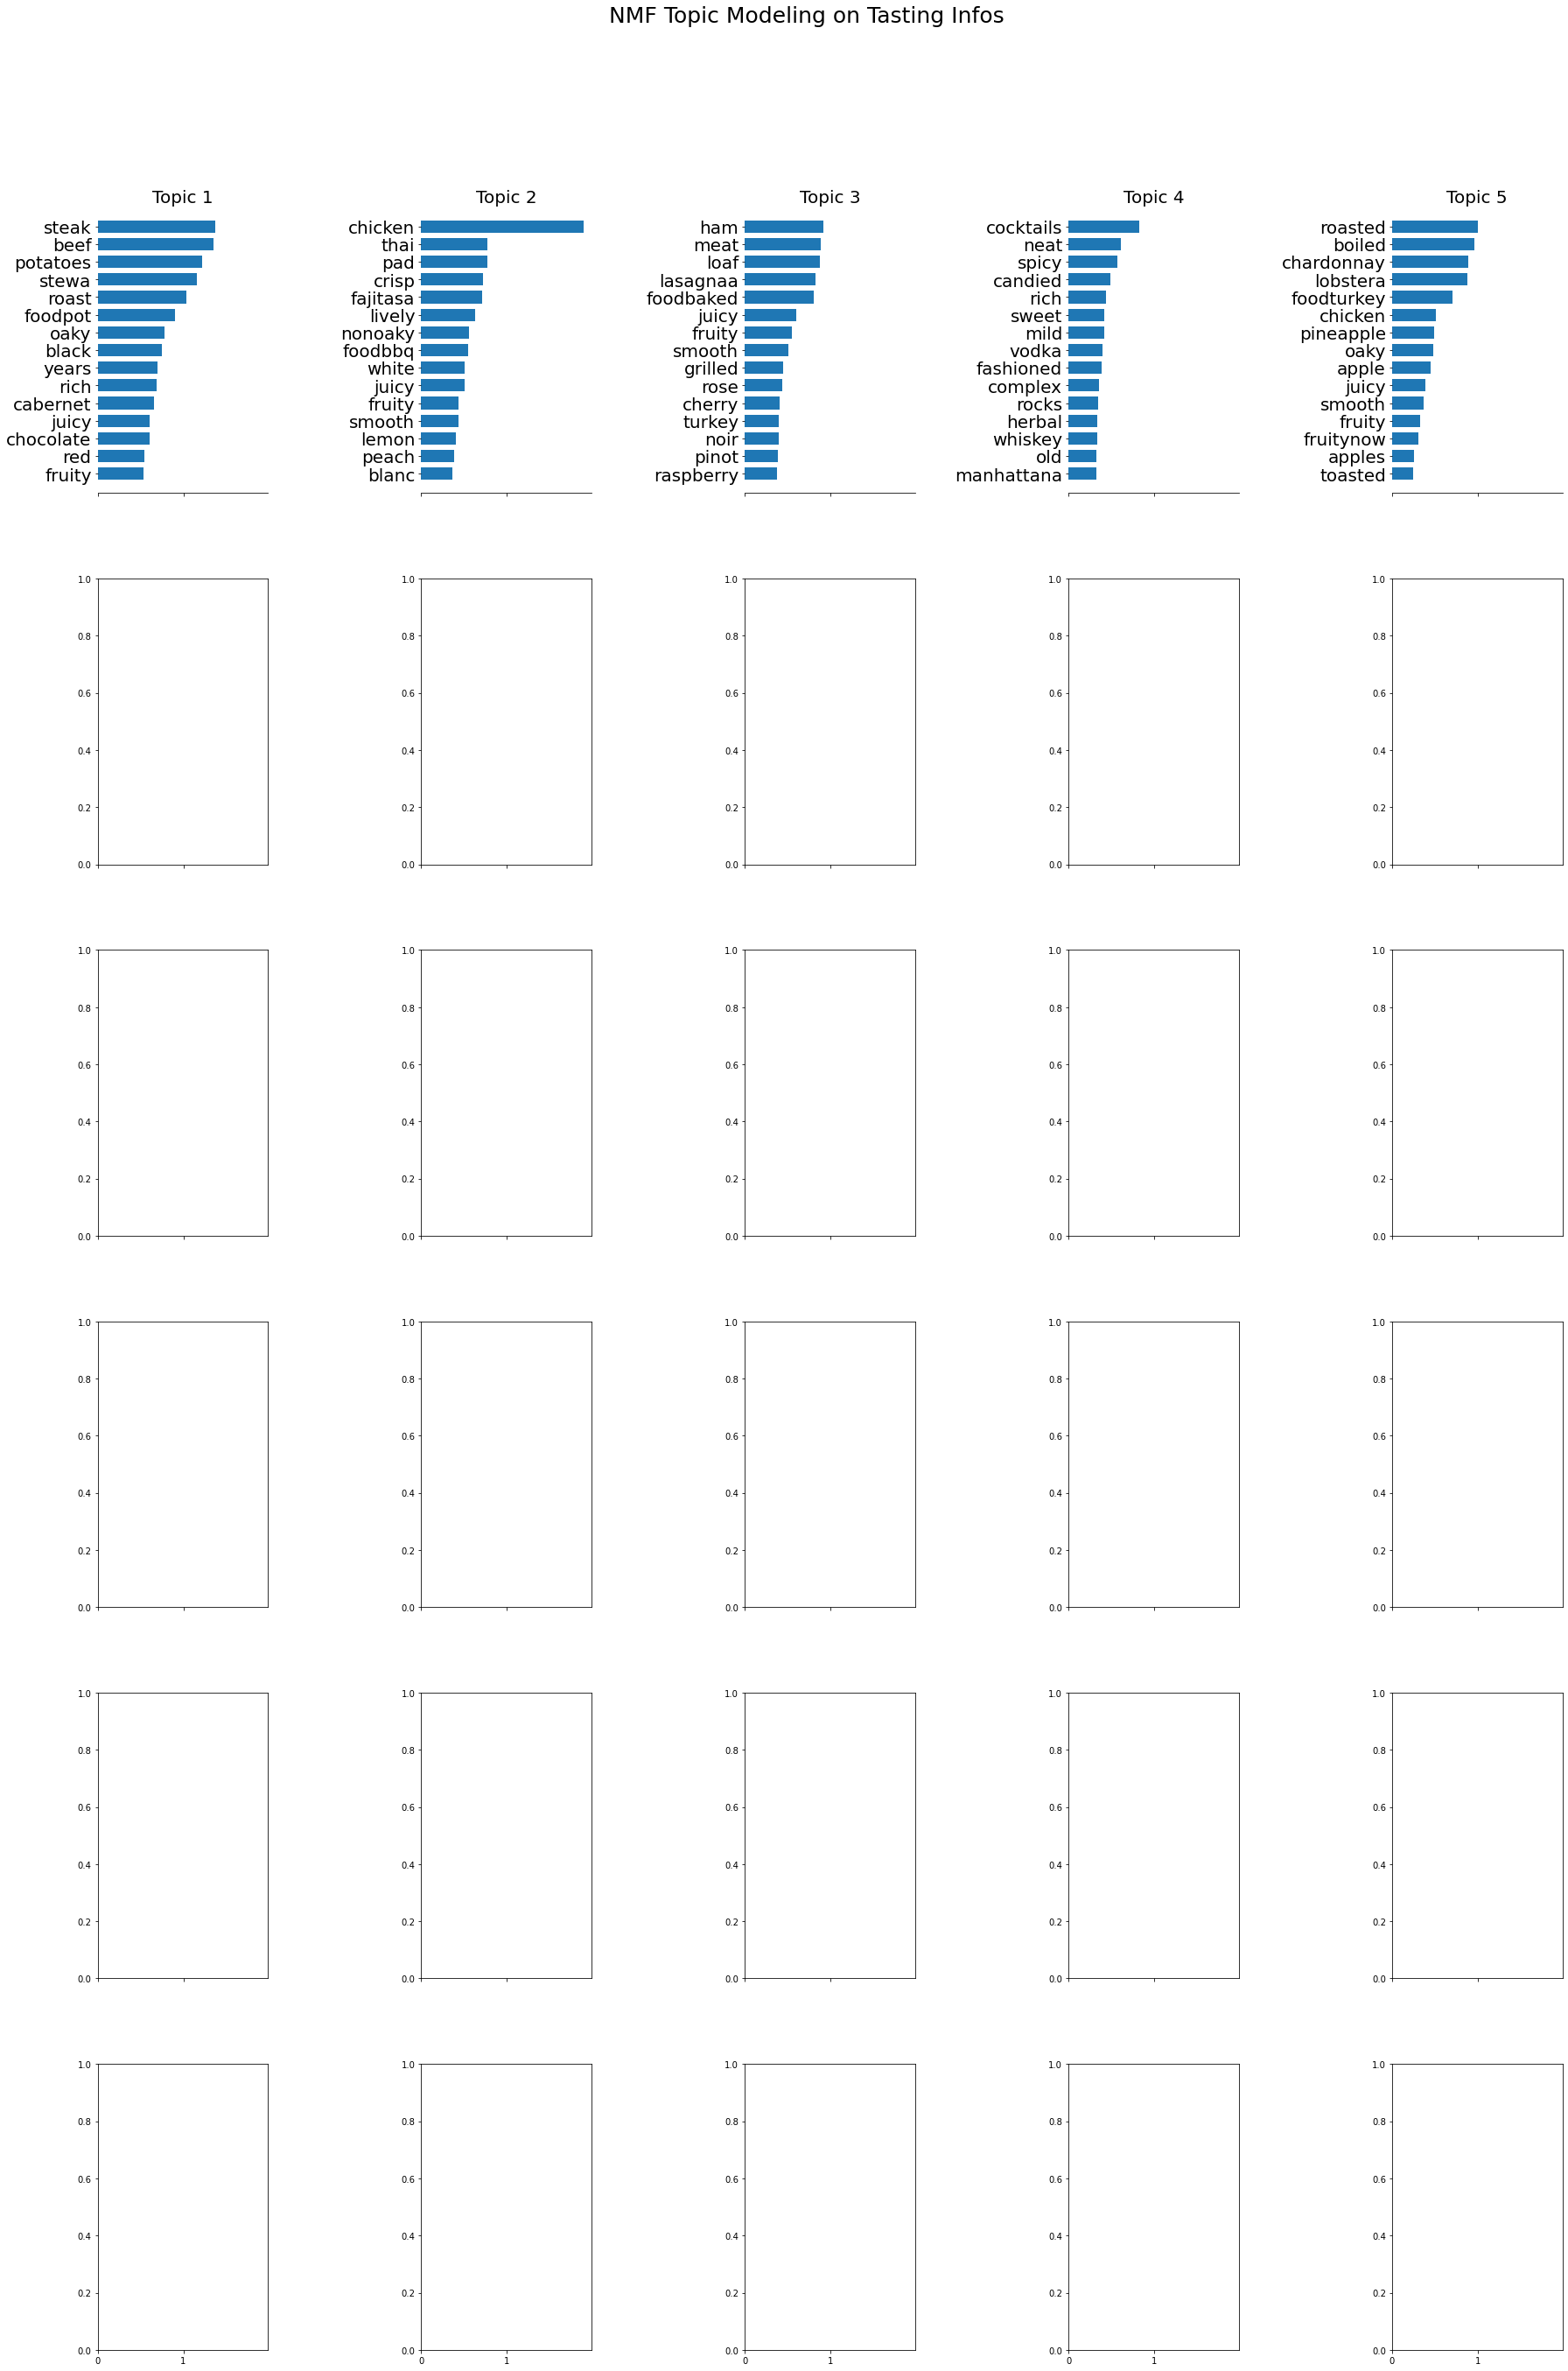

In [37]:
plot_top_words(nmf_tas, vocabs_tas, 15, "NMF Topic Modeling on Tasting Infos")

In [186]:
df.Tasting_Info

0       Fruity, Funky, Rich, Spicy, Smoky, Herbal & Co...
1       Fruity, Complex, Candied, Herbal, Rich & Spicy...
2       Complex, Fruity & Herbal | pickled melon and p...
3       Fruity, Spicy & Herbal | honey-drizzled grapef...
4       Fruity, Rich & Spicy | toffee coated popcorn, ...
                              ...                        
8314    Funky | apple cider vinegar, new sneakers, and...
8315    Sweet & Fruity & Funky | orange creamsicle, ap...
8316    Crisp & Light & Sweet & Fruity | pinot grigio,...
8317    Crisp & Light & Funky | frosted cereal, raisin...
8318    Funky | green apple candy, butterscotch, perma...
Name: Tasting_Info, Length: 8319, dtype: object

In [163]:
tas_word_df = pd.DataFrame(nmf_tas.components_.round(5), columns=vocabs_tas).T.add_prefix('topic_')

In [32]:
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
test_item = ['chicken']
topic_prob_dist = nmf_tas.transform(tfidf_tas.transform(test_item))
list_top_items_by_indices = list(cosine_similarity(topic_prob_dist, tas_matrix).argsort())[0][-1:-21:-1]
full_df.iloc[list_top_items_by_indices].sort_values(by='Points', ascending=False)[:10]['Enjoy']


2327    Now on its own and with food
1843    Now on its own and with food
858     Now on its own and with food
4112    Now on its own and with food
1103    Now on its own and with food
4774    Now on its own and with food
7559                  Now on its own
748     Now on its own and with food
747                              Now
1108    Now on its own and with food
Name: Enjoy, dtype: object

In [166]:
full_df.columns

Index(['Name', 'Description', 'Category', 'Country', 'Alcohol_Vol', 'Review',
       'Style', 'Aroma', 'Flavor', 'Sweetness', 'Bitterness', 'Enjoy',
       'Pairing', 'Cocktails', 'Bottom_Line', 'Points', 'Price',
       'Points_Ranking', 'Price_Range', 'Extend_Review', 'Photo_Link', 'Medal',
       'Bands', 'Medal_Rank', 'Bands_Rank'],
      dtype='object')

In [41]:
nmf_tas

NMF(n_components=5)

In [44]:
import pickle
with open('topics_by_tasting.pkl', 'wb') as wf:
    pickle.dump(tas_df, wf)
with open('topics_by_tasting_matrix.pkl', 'wb') as wf:
    pickle.dump(tas_matrix, wf)
with open('tfidf_tasting.pkl', 'wb') as wf:
    pickle.dump(tfidf_tas, wf)
with open('nmf_tasting.pkl', 'wb') as wf:
    pickle.dump(nmf_tas, wf)

In [45]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8319 entries, 0 to 8318
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            8319 non-null   object 
 1   Description     8319 non-null   object 
 2   Category        7322 non-null   object 
 3   Country         7317 non-null   object 
 4   Alcohol_Vol     7322 non-null   object 
 5   Review          7322 non-null   object 
 6   Style           7286 non-null   object 
 7   Aroma           7303 non-null   object 
 8   Flavor          7301 non-null   object 
 9   Sweetness       5225 non-null   object 
 10  Bitterness      438 non-null    object 
 11  Enjoy           7303 non-null   object 
 12  Pairing         5509 non-null   object 
 13  Cocktails       1315 non-null   object 
 14  Bottom_Line     7322 non-null   object 
 15  Points          6224 non-null   float64
 16  Price           6554 non-null   float64
 17  Points_Ranking  6224 non-null   o

#### Topic_0

In [30]:
for tasting in tas_df.sort_values(by='topic_0', ascending=False).head(10)['Tasting_Info'].values:
    print(tasting)
    print('\n')
tas_word_df.sort_values(by='topic_0', ascending=False).head(10).topic_0

fruity oaky rich  full  spicy  complex  red cassis cinnamon pastry and black olives  smoked meats dates chocolate and licorice  dryyetfruityin  years on its own and with foodpot roast steak  potatoes beef stewa slightly savory cabernet with excellent balance a great steak pairing


fruity juicy  smooth oaky rich  full  new world  black cassis licorice jalepeño and cracked peppercorns  same as aromas with notes of tobacco nutmeg and chocolate cookies  fruitynow years on its own and with foodpot roast steak  potatoes beef stewa rich and velvety napa cabernet for oaklovers


oaky  rich  full  figs leather and cherry pie  chocolate and graphite  fruitynow on its own and with foodpot roast steak  potatoes beef stewa sturdy red for the table


juicy  smooth oaky  spicy  complex  rich plum pie black olives sarsaparilla vanilla gelato cedar and new leather  sour plum  fruitynow with foodpot roast steak  potatoes beef stewa bold and spicy cabernet sauvignon that will be a lovely complement to f

NameError: name 'tas_word_df' is not defined

#### Topic_1

In [40]:
for tasting in tas_df.sort_values(by='topic_1', ascending=False).head(10)['Tasting_Info'].values:
    print(tasting)
    print('\n')
tas_word_df.sort_values(by='topic_1', ascending=False).head(10).topic_1

fruity  juicy  smooth  white peach honeysuckle and ripe pear  smooth crisp  fruitynow on its own and with foodbbq chicken pad thai chicken chicken fajitasa crisp and fruity white in a crowdpleasing style


fruity juicy  smooth crisp  lively  nonoaky  honey white blossoms and pears in cream  same as aromas with accents of white grapefruit  dryishnow on its own and with foodbbq chicken pad thai chicken chicken fajitasa concentrated yet restrained sauvignon blanc


crisp  lively fruity juicy  smooth quaffable  nonoaky  pineapple mango peach diced green pepper and lanolin  kiwi and lime  dryyetfruitynow on its own and with foodbbq chicken pad thai chicken chicken fajitasa crisp sauvignon blanc with refreshing notes of citrus


fruity crisp  lively juicy  smooth  nonoaky  fallen peach  meyer lemon and cream  dryishnow on its own and with foodbbq chicken pad thai chicken chicken fajitasa mellow sauvignon blanc in a snappy style


juicy  smooth fruity  nonoaky  ripe pear passion fruit custard

chicken     1.87466
thai        0.92006
pad         0.91941
fajitasa    0.83035
foodbbq     0.66780
crisp       0.50864
white       0.47264
nonoaky     0.46621
lively      0.44435
blanc       0.43776
Name: topic_1, dtype: float64

In [41]:
for tasting in tas_df.sort_values(by='topic_7', ascending=False).head(10)['Tasting_Info'].values:
    print(tasting)
    print('\n')
tas_word_df.sort_values(by='topic_7', ascending=False).head(10).topic_7

mild  minerals    in cocktailsbloody mary moscow mule vodka martinia peppery vodka that packs a punch a solid bloody mary vodka


mild  lemon zest  same as aromas with notes of white pepper marshmallow and mineral water  in cocktailsbloody mary moscow mule vodka martinia citruskissed mild vodka for anytime cocktails


candied  mild  smarties candies and orange cooler  hints of watermelon and white pepper  in cocktailsbloody mary moscow mule vodka martinia mild candied vodka to slip into your vodka highball


mild  fresh lemon zest  same as aromas with impressions of minerals and water crackers  in cocktailsbloody mary moscow mule vodka martinia citrusy vodka that will work well in fruity shaken cocktails


mild  hints of fresh cream glacial ice and vanilla pod  same as aromas with notes of lemon pepper on water cracker  in cocktails neat and on the rocksbloody mary moscow mule vodka martinia clean crisp smoothsipping vodka for a great martini


juicy  smooth  dried lime and cream  same

vodka        1.77180
martinia     0.80218
mule         0.73834
moscow       0.69155
mild         0.47285
mary         0.44719
lemon        0.42517
cocktails    0.37687
hints        0.34201
martini      0.25909
Name: topic_7, dtype: float64

In [42]:
df

,Name,Description,Full_Review,Tasting_Info
0,Mezcal de Leyendas Verde San Luis Potosi Mezca...,Mezcal de Leyendas Review Verde San Luis Potos...,"Clear color. Aromas and flavors of cucumber, m...","Fruity, Funky, Rich, Spicy, Smoky, Herbal & Co..."
1,El Tesoro Paradiso Tequila Extra Anejo Mexico ...,El Tesoro Review Paradiso Tequila Extra Anejo ...,"Gold color. Inviting aromas of roasted nuts, c...","Fruity, Complex, Candied, Herbal, Rich & Spicy..."
2,Peloton de la Muerte Vegan Pechuga Mezcal Mexi...,Peloton de la Muerte Review Vegan Pechuga Mezc...,Silvery straw color. Citrusy aromas and flavor...,"Complex, Fruity & Herbal | pickled melon and p..."
3,El Tesoro Anejo Tequila Mexico Spirits,El Tesoro Review Anejo Tequila Mexico Mexican ...,Straw color. Inviting aromas and flavors of ho...,"Fruity, Spicy & Herbal | honey-drizzled grapef..."
4,1800 Milenio Extra Anejo Tequila Mexico Spirits,1800 Review Milenio Extra Anejo Tequila Mexico...,"Amber color. Aromas of toffee coated popcorn, ...","Fruity, Rich & Spicy | toffee coated popcorn, ..."
...,...,...,...,...
8314,Angry Orchard Super Natural Cider USA Cider,Angry Orchard Review Super Natural Cider MA Ma...,Straw green color. Aromas of apple cider vineg...,"Funky | apple cider vinegar, new sneakers, and..."
8315,Avid Cider Co Apricot Cider USA Cider,Avid Cider Review Apricot Cider OR Oregon USA ...,"Light gold color. Aromas of orange creamsicle,...","Sweet & Fruity & Funky | orange creamsicle, ap..."
8316,Magnotta Craft Ciders Apple Flavored Cider Can...,Magnotta Craft Ciders Review Apple Flavored Ci...,"Silvery straw color. Aromas of pinot grigio, p...","Crisp & Light & Sweet & Fruity | pinot grigio,..."
8317,Topa Brut Artisanal Cidre France Cider,Topa Review Brut Artisanal Cidre France French...,Gold color. Aromas and flavors of frosted cere...,"Crisp & Light & Funky | frosted cereal, raisin..."


## Pairing topic modeling

In [191]:
full_df.Pairing.value_counts()

Pot Roast, Steak & Potatoes, Beef Stew                                                           699
Baked Ham, Meat Loaf, Lasagna                                                                    538
BBQ Chicken, Pad Thai Chicken, Chicken Fajitas                                                   439
Turkey, Roasted Chicken, Boiled Lobster                                                          322
Baked Ham, Turkey, Grilled Salmon                                                                232
                                                                                                ... 
Sautéed Bay Scallops With A Beurre Blanc Sauce, Scallops With Chorizo Butter, Chicken Fajitas      1
Spiced Popcorn, Chicken Kebobs, BBQ Chicken                                                        1
Lemon Pepper Roasted Chicken, Roasted Chicken, Boiled Lobster                                      1
Duck Fajitas, Ham With Mostarda, Cobb Salad                                                

In [6]:
pairings = full_df['Pairing'].fillna('')

pairings = text_cleaning(pairings)

tfidf_pair = TfidfVectorizer(stop_words=stop_words,
                           min_df=3,
                           max_df=0.7)

pair_matrix = tfidf_pair.fit_transform(pairings) #sparse matrix 

vocabs_pair = tfidf_pair.get_feature_names()

nmf_pair = NMF(n_components=10)

nmf_pair.fit(pair_matrix)

pair_matrix = nmf_pair.transform(pair_matrix) #topic prob dist

pair_df = pd.DataFrame(pair_matrix).add_prefix('topic_')
pair_df['Pairing'] = pairings
pair_df.tail(20)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,Pairing
8299,0.000000,0.021765,0.000000,0.000000,0.089448,0.011230,0.000498,0.000000,0.000122,0.019822,chicken schnitzel veggie frittata grilled salmon
8300,0.000000,0.000000,0.000000,0.000000,0.100215,0.005349,0.007729,0.000384,0.000176,0.050781,pork chops veggie frittata grilled salmon
8301,0.000000,0.000000,0.000000,0.000000,0.100215,0.005349,0.007729,0.000384,0.000176,0.050781,pork chops veggie frittata grilled salmon
8302,0.000000,0.000000,0.000000,0.000000,0.088716,0.007527,0.008011,0.002995,0.000985,0.034127,pork chops cuban sandwich grilled salmon
8303,0.000000,0.000000,0.033052,0.000000,0.039103,0.000000,0.000000,0.001591,0.000287,0.015631,spaghetti carbonara veggie frittata baked ham
8304,0.000000,0.000000,0.000000,0.000000,0.004413,0.141901,0.004339,0.000144,0.000000,0.029453,pork chops cobb salad chicken caesar salad
8305,0.000000,0.000000,0.000000,0.000000,0.100215,0.005349,0.007729,0.000384,0.000176,0.050781,pork chops veggie frittata grilled salmon
8306,0.000061,0.062989,0.000269,0.005546,0.002364,0.077344,0.008383,0.000000,0.000000,0.031228,pork chops chicken kebobs bbq chicken
8307,0.000061,0.062989,0.000269,0.005546,0.002364,0.077344,0.008383,0.000000,0.000000,0.031228,pork chops chicken kebobs bbq chicken
8308,0.000062,0.079669,0.000515,0.000196,0.001051,0.056620,0.002706,0.000000,0.000189,0.013909,bbq pork chicken kebobs bbq chicken


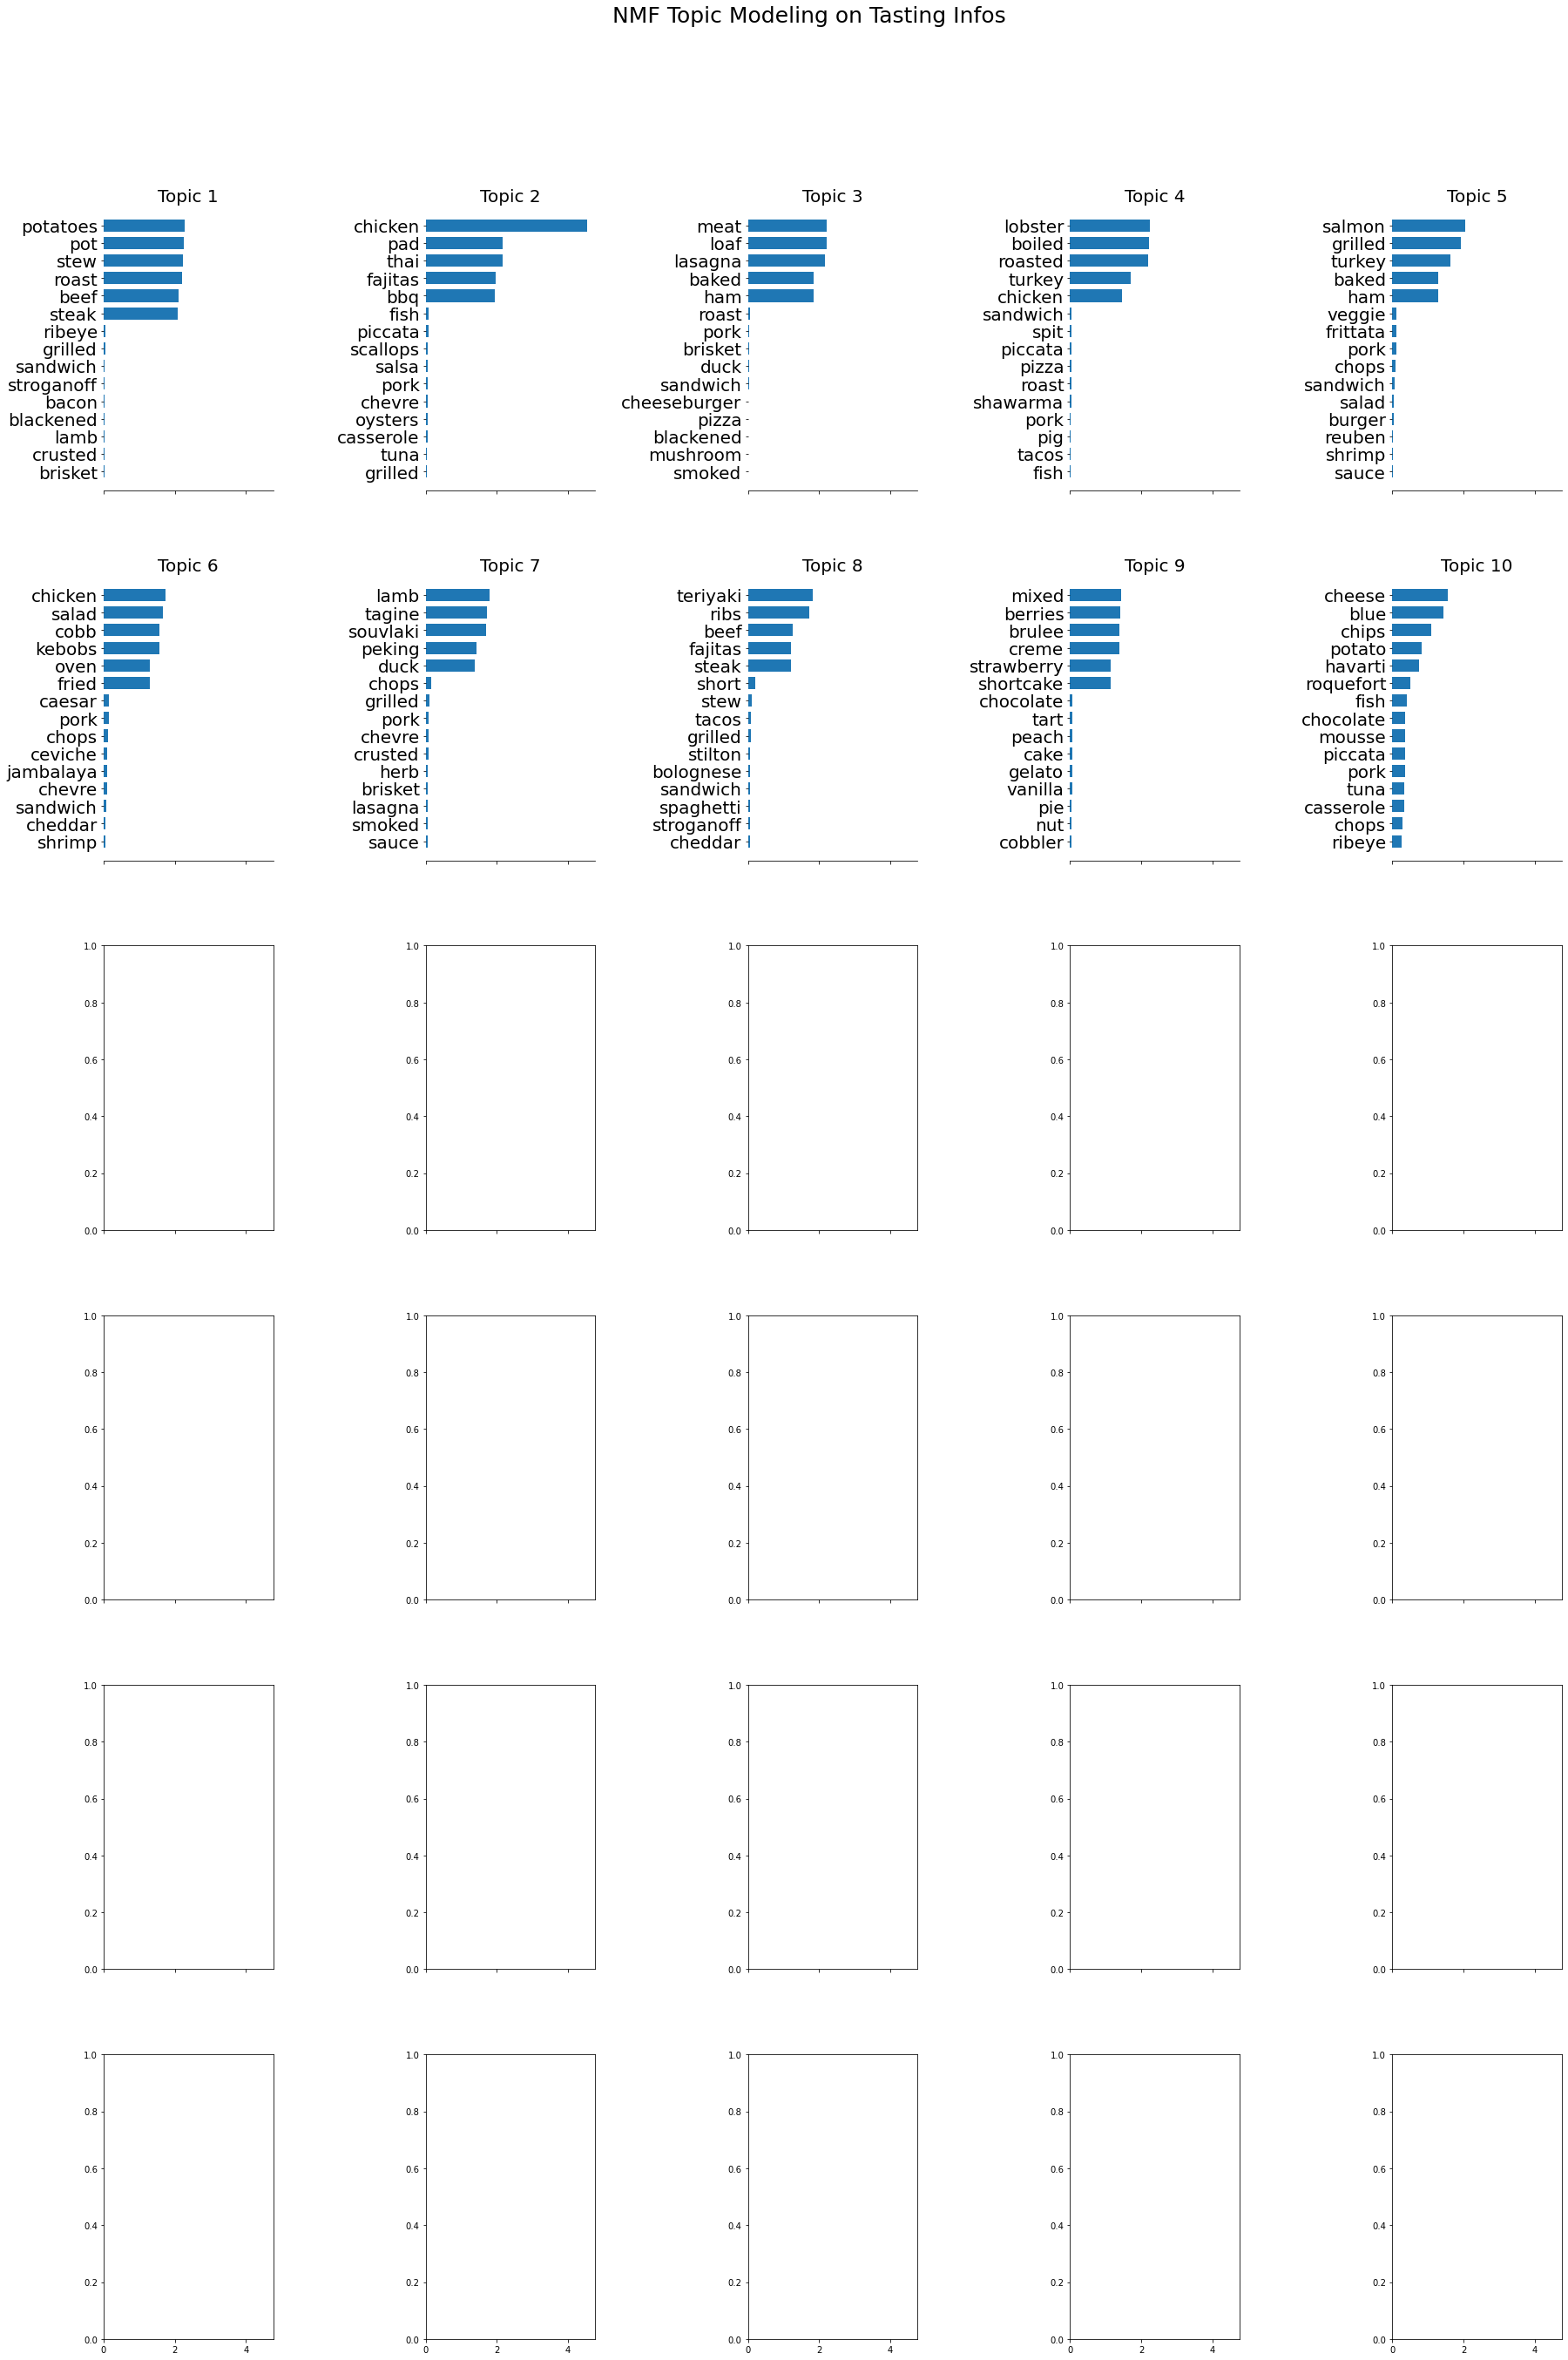

In [7]:
plot_top_words(nmf_pair, vocabs_pair, 15, "NMF Topic Modeling on Tasting Infos")

In [199]:
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
test_item = ['chicken']
topic_prob_dist = nmf_pair.transform(tfidf_pair.transform(test_item))
list_top_items_by_indices = list(cosine_similarity(topic_prob_dist, pair_matrix).argsort())[0][-1:-200:-1]
full_df.iloc[list_top_items_by_indices].sort_values(by='Points', ascending=False)[:5].Pairing.values


array(['Jambalaya, Chicken Shawarma, Neufchatel',
       'Skirt Steak with Mole, Chicken Kebobs, BBQ Chicken',
       'Roasted Chicken, BBQ Chicken, Port Salut',
       'Chicken Salad Sandwich, Fresh Trout With Brown Butter, Chicken Fajitas',
       'Orange Chicken, Aged Cheddar Cheeseburger, Provolone'],
      dtype=object)

## Cocktails

### By ingredients

In [29]:
full_cocktails = pd.read_csv('../data/full_cocktails.csv', index_col=0).reset_index()
full_cocktails.drop(columns='index' ,inplace=True)

In [30]:
full_cocktails.tail()

,Name,Category,Instructions,Serve_In,Photo_Link,Ingredients,Description
1540,"Bear With Me, Honey",NaN,"Add the gin, egg white, verjus, honey syrup, o...",NaN,https://www.liquor.com/thmb/86n4O9QMFLxeEZX17n...,"1 1/2 ounces Barr Hill Tom Cat gin, 1 egg whit...",A riff on a Bee’s Knees—a classic Prohibition-...
1541,Dark Side,NaN,"Add the gin, Barolo chinato and bitters into a...",NaN,https://www.liquor.com/thmb/iAaIK1v1aR_qzsp0VL...,"2 1/2 ounces gin, 3/4 ounce Barolo chinato, 3 ...",The Dark Side cocktail was created by Washingt...
1542,CBD Gin & Tonic,NaN,Pour all ingredients into a highball glass ove...,NaN,https://www.liquor.com/thmb/GpHZlLtzHz9udqihFK...,"2 oz Tanqueray Rangpur gin, 4 oz Aurora hemp-i...",Who doesn’t love a classic Gin & Tonic? The tw...
1543,Crystal Ramos Gin Fizz,NaN,"Serves 2. In a carbonator bottle, combine gin,...",NaN,https://www.liquor.com/thmb/vx4OnNoNA31K9S-0Vt...,"1 1/4 cups Tanqueray gin, 6 3/4 cups clarified...","“I’m not a big fan of creamy cocktails,” says ..."
1544,CBD Dirty Martini,NaN,Add all ingredients into a mixing glass with i...,NaN,https://www.liquor.com/thmb/rW7krxPxHfKpFkhoYp...,"2 ounces dry gin, 1/2 ounce extra dry vermouth...",The cocktail scene is a constantly developing ...


In [44]:
full_cocktails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1545 entries, 0 to 1544
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          1545 non-null   object
 1   Category      546 non-null    object
 2   Instructions  1407 non-null   object
 3   Serve_In      1013 non-null   object
 4   Photo_Link    839 non-null    object
 5   Ingredients   1287 non-null   object
 6   Description   243 non-null    object
dtypes: object(7)
memory usage: 84.6+ KB


In [79]:
sw_cocktails_ingr = ['color', 'colors', 'aroma', 'aromas', 'flavor', 'flavors', 'review', 'taste', 
                'tasting', 'pair', 'pairing', 'oz', 'simple', 'dash', 'bsp', 'drops', 'cocktail',
               'cocktails', 'stir', 'serve', 'shake']
stop_words_cocktails_ingr = ENGLISH_STOP_WORDS.union(sw_cocktails_ingr)

In [76]:
cocktails_with_photos = full_cocktails.dropna(subset=['Photo_Link'], axis = 0).reset_index().drop(columns='index')


In [77]:
cocktails_with_photos.tail()

,Name,Category,Instructions,Serve_In,Photo_Link,Ingredients,Description
834,"Bear With Me, Honey",NaN,"Add the gin, egg white, verjus, honey syrup, o...",NaN,https://www.liquor.com/thmb/86n4O9QMFLxeEZX17n...,"1 1/2 ounces Barr Hill Tom Cat gin, 1 egg whit...",A riff on a Bee’s Knees—a classic Prohibition-...
835,Dark Side,NaN,"Add the gin, Barolo chinato and bitters into a...",NaN,https://www.liquor.com/thmb/iAaIK1v1aR_qzsp0VL...,"2 1/2 ounces gin, 3/4 ounce Barolo chinato, 3 ...",The Dark Side cocktail was created by Washingt...
836,CBD Gin & Tonic,NaN,Pour all ingredients into a highball glass ove...,NaN,https://www.liquor.com/thmb/GpHZlLtzHz9udqihFK...,"2 oz Tanqueray Rangpur gin, 4 oz Aurora hemp-i...",Who doesn’t love a classic Gin & Tonic? The tw...
837,Crystal Ramos Gin Fizz,NaN,"Serves 2. In a carbonator bottle, combine gin,...",NaN,https://www.liquor.com/thmb/vx4OnNoNA31K9S-0Vt...,"1 1/4 cups Tanqueray gin, 6 3/4 cups clarified...","“I’m not a big fan of creamy cocktails,” says ..."
838,CBD Dirty Martini,NaN,Add all ingredients into a mixing glass with i...,NaN,https://www.liquor.com/thmb/rW7krxPxHfKpFkhoYp...,"2 ounces dry gin, 1/2 ounce extra dry vermouth...",The cocktail scene is a constantly developing ...


In [145]:
ingredients = cocktails_with_photos['Ingredients'].fillna('')

ingredients = text_cleaning(ingredients)

tfidf_ingredients = TfidfVectorizer(stop_words=stop_words_cocktails_ingr,
                           min_df=2,
                           max_df=0.8,
                            ngram_range=(1,2)) #tfidf vectorizer: used to transform new text data to to through the nmf

ingredients_matrix = tfidf_ingredients.fit_transform(ingredients)

vocabs_ingredients = tfidf_ingredients.get_feature_names()

nmf_ingredients = NMF(10)

ingredients_matrix = nmf_ingredients.fit_transform(ingredients_matrix) #nmf model to transform new text data

ingredients_df = pd.DataFrame(ingredients_matrix).add_prefix('topic_')

ingredients_df['Ingredients'] = cocktails_with_photos['Ingredients']

ingredients_df.tail()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,Ingredients
834,0.091994,0.036640,0.003754,0.001719,0.000000,0.006805,0.000000,0.021160,0.035781,0.026186,"1 1/2 ounces Barr Hill Tom Cat gin, 1 egg whit..."
835,0.021192,0.000000,0.031956,0.000000,0.000000,0.013312,0.000000,0.000000,0.183900,0.000000,"2 1/2 ounces gin, 3/4 ounce Barolo chinato, 3 ..."
836,0.006574,0.000000,0.026049,0.000000,0.000000,0.001005,0.000000,0.000000,0.012195,0.175549,"2 oz Tanqueray Rangpur gin, 4 oz Aurora hemp-i..."
837,0.000000,0.005222,0.040368,0.002769,0.039945,0.016740,0.004038,0.000000,0.028179,0.008222,"1 1/4 cups Tanqueray gin, 6 3/4 cups clarified..."
838,0.055581,0.000000,0.121582,0.000000,0.000000,0.000000,0.000000,0.005928,0.019471,0.026506,"2 ounces dry gin, 1/2 ounce extra dry vermouth..."


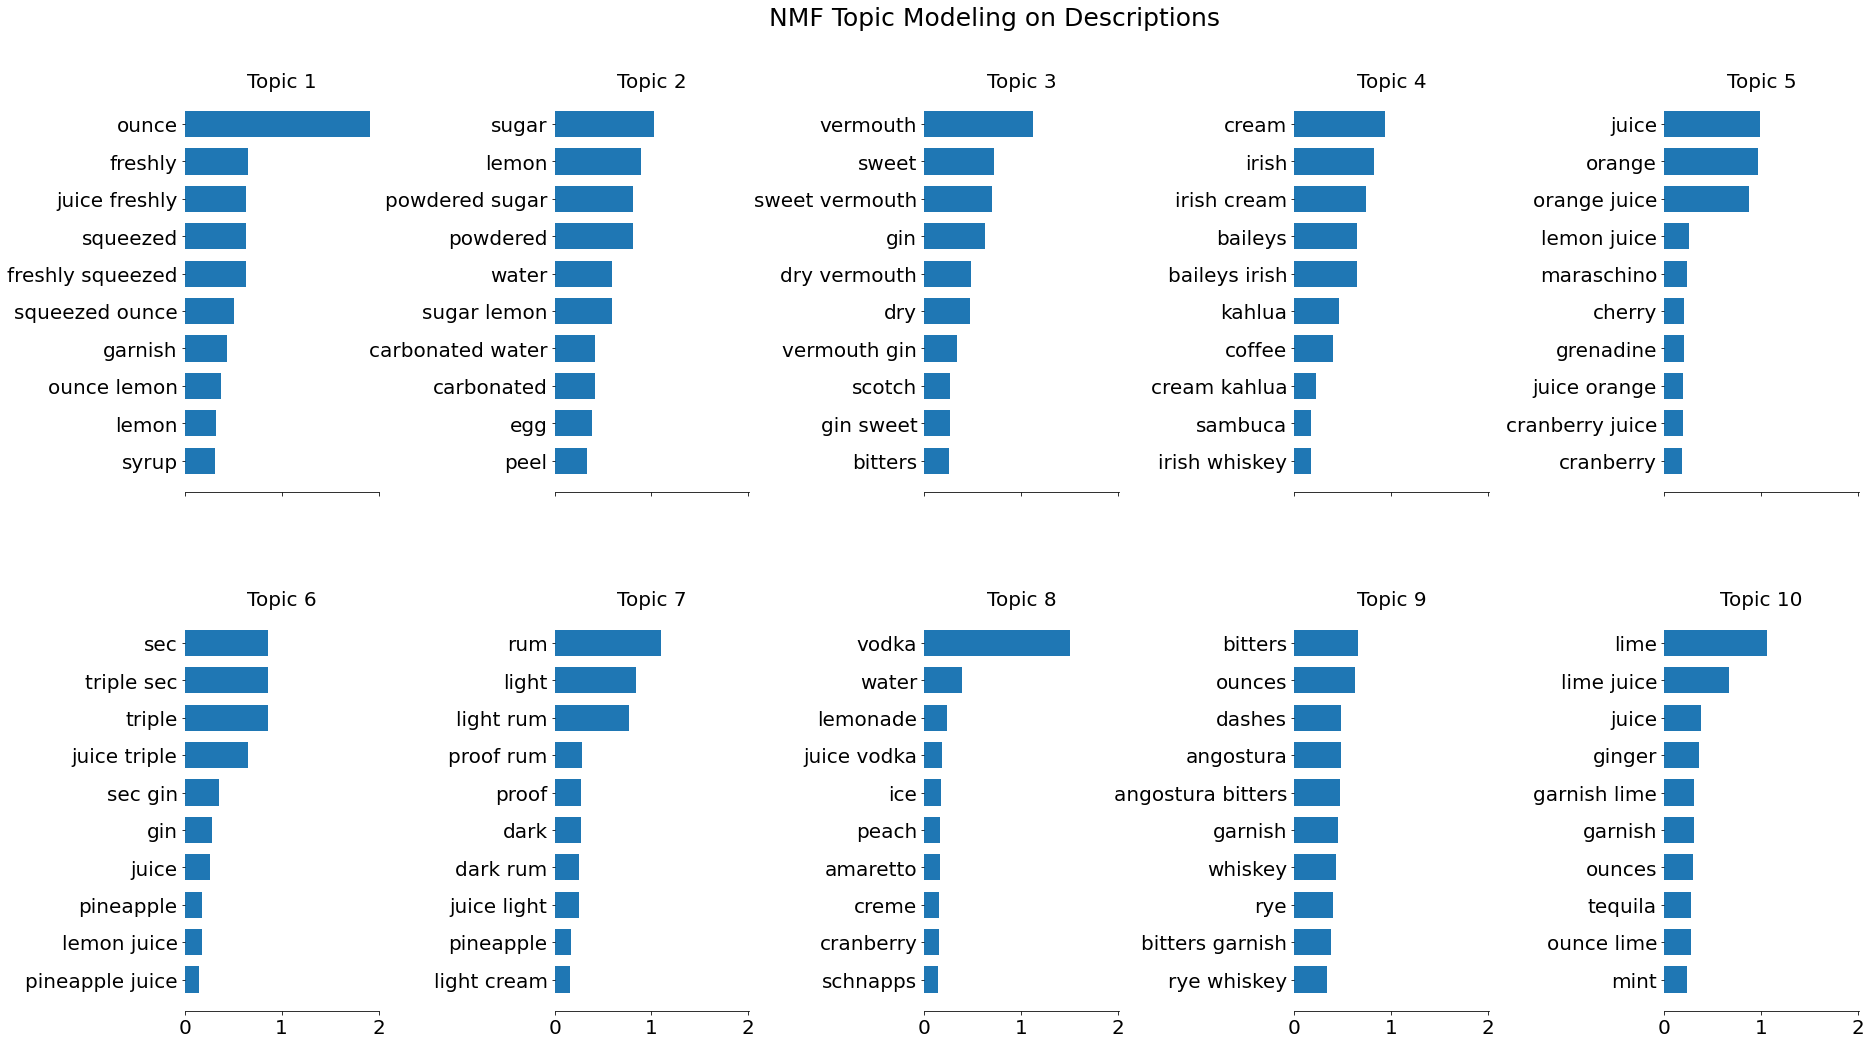

In [146]:
plot_top_words(nmf_ingredients, vocabs_ingredients, 10, "NMF Topic Modeling on Descriptions")

In [147]:
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
test_item = ['rum']
topic_prob_dist = nmf_ingredients.transform(tfidf_ingredients.transform(test_item))
list_top_items_by_indices = list(cosine_similarity(topic_prob_dist, ingredients_matrix).argsort())[0][-1:-21:-1]
top_items = full_cocktails.iloc[list_top_items_by_indices]
top_items

,Name,Category,Instructions,Serve_In,Photo_Link,Ingredients,Description
6,252,Shot,"Add both ingredients to shot glass, shoot, and...",Shot glass,http://www.thecocktaildb.com/images/media/drin...,"Wild Turkey, 151 proof rum,",NaN
27,ACID,Shot,Poor in the 151 first followed by the 101 serv...,Shot glass,http://www.thecocktaildb.com/images/media/drin...,"Wild Turkey, 151 proof rum,",NaN
368,Miami Vice,Cocktail,First: Mix pina colada with 2.5 oz. of rum wit...,Cocktail glass,http://www.thecocktaildb.com/images/media/drin...,"Daiquiri mix, Pina colada mix, 151 proof rum,",NaN
356,Lord And Lady,Ordinary Drink,Pour the rum and Tia Maria into an old-fashion...,Old-fashioned glass,http://www.thecocktaildb.com/images/media/drin...,"Tia maria, Dark rum,",NaN
402,Pina Colada,Ordinary Drink,Mix with crushed ice in blender until smooth. ...,Collins glass,http://www.thecocktaildb.com/images/media/drin...,"Pineapple, Coconut milk, Light rum,",NaN
334,Kool First Aid,Shot,"Add Kool Aid to a double shot glass, and top w...",Shot glass,http://www.thecocktaildb.com/images/media/drin...,"Kool-Aid, 151 proof rum,",NaN
5,24k nightmare,Shot,"Add over ice,shake and pour.",Shot glass,http://www.thecocktaildb.com/images/media/drin...,"151 proof rum, Rumple Minze, Jägermeister, Gol...",NaN
3,151 Florida Bushwacker,Milk / Float / Shake,Combine all ingredients. Blend until smooth. G...,Beer mug,http://www.thecocktaildb.com/images/media/drin...,"Vanilla ice-cream, Coconut liqueur, Milk, Coin...",NaN
417,Quaker's Cocktail,Ordinary Drink,"Shake all ingredients with ice, strain into a ...",Cocktail glass,http://www.thecocktaildb.com/images/media/drin...,"Raspberry syrup, Lemon, Brandy, Light rum,",NaN
224,Downshift,Punch / Party Drink,Start with the Sprite. Next comes the tequila....,Hurricane glass,http://www.thecocktaildb.com/images/media/drin...,"151 proof rum, Tequila, Sprite, Fruit punch,",NaN


In [59]:
full_cocktails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1545 entries, 0 to 1544
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          1545 non-null   object
 1   Category      546 non-null    object
 2   Instructions  1407 non-null   object
 3   Serve_In      1013 non-null   object
 4   Photo_Link    839 non-null    object
 5   Ingredients   1287 non-null   object
 6   Description   243 non-null    object
dtypes: object(7)
memory usage: 84.6+ KB


In [153]:
import pickle
with open('cocktails_with_photos.pkl', 'wb') as wf:
    pickle.dump(cocktails_with_photos, wf)

### By name

In [85]:
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
from nltk.metrics import edit_distance

In [89]:
'manhttan'[:5]

'manht'

In [93]:
cocktails_with_photos.Name.iloc[0]

"'57 Chevy with a White License Plate"

In [194]:
test_string = 'gin and your dick'
n = len(test_string)

distances = []

for i in range(len(cocktails_with_photos)):
    
    dist = edit_distance(test_string.lower(), cocktails_with_photos.Name.iloc[i].strip().lower()[:n])
    
    distances.append(dist)

cocktails_with_photos['Distance'] = pd.DataFrame(distances, columns={'Distance'}).Distance

top_items = cocktails_with_photos.sort_values(by='Distance').head(8).fillna('N/A')

In [195]:
top_items

,Name,Category,Instructions,Serve_In,Photo_Link,Ingredients,Description,Distance
262,Gin And Tonic,Ordinary Drink,Pour the gin and the tonic water into a highba...,Highball glass,http://www.thecocktaildb.com/images/media/drin...,N/A,N/A,6
584,Island Oasis,N/A,Add all ingredients into a shaker with ice and...,N/A,https://www.liquor.com/thmb/AABXT19PLo3BPidw3d...,"2 ounces aged rum, 2 ounces coconut water, 1 o...",This festive cocktail was created by bartender...,10
269,Gin Sour,Ordinary Drink,"In a shaker half-filled with ice cubes, combin...",Whiskey sour glass,http://www.thecocktaildb.com/images/media/drin...,"Maraschino cherry, Orange, Sugar, Lemon juice,...",N/A,10
264,Gin Daisy,Ordinary Drink,"In a shaker half-filled with ice cubes, combin...",Old-fashioned glass,http://www.thecocktaildb.com/images/media/drin...,"Orange, Maraschino cherry, Grenadine, Sugar, L...",N/A,11
170,Brandy Sour,Ordinary Drink,"Shake brandy, juice of lemon, and powdered sug...",Whiskey sour glass,http://www.thecocktaildb.com/images/media/drin...,N/A,N/A,11
331,Kiss me Quick,Ordinary Drink,mix in the glass,Highball glass,http://www.thecocktaildb.com/images/media/drin...,"Ice, Apple juice, Schweppes Russchian, Apfelko...",N/A,11
266,Gin Rickey,Cocktail,Half-fill a tall glass with ice. Mix the gin a...,Highball glass,http://www.thecocktaildb.com/images/media/drin...,"Lime, Soda Water, lemon, Grenadine, Gin,",N/A,11
279,Grand Blue,Ordinary Drink,Serve in an old fashioned glass.,Old-fashioned glass,http://www.thecocktaildb.com/images/media/drin...,"Sweet and sour, Blue Curacao, Peach schnapps, ...",N/A,11


In [196]:
print('**Name:** {}\n\n**Category:** {}\n\n**Ingredients:** {}\n\n**Instructions:** {}\n\n**Serve in:** {}'
                     .format(top_items.iloc[i].Name, top_items.iloc[i].Category, top_items.iloc[i].Ingredients, top_items.iloc[i].Instructions,
                             top_items.iloc[i].Serve_In))

**Name:** Gin And Tonic

**Category:** Ordinary Drink

**Ingredients:** N/A

**Instructions:** Pour the gin and the tonic water into a highball glass almost filled with ice cubes. Stir well. Garnish with the lime wedge.

**Serve in:** Highball glass
